# Labs Access Analysis: 03 City Map Plot

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import json
pd.options.mode.chained_assignment = None
import branca.colormap as cmp
import os
import time
import folium
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore') # ignore warnings

In [2]:
sns.set_context("poster")
sns.set_style("ticks")
matplotlib.rc('font', family='serif', serif='Fira Sans')

In [3]:
url_data_labs = "data/labs.csv"
url_data_isochrones = "data/isochrones.json"

In [4]:
# Load data, json
with open(url_data_isochrones) as json_file:
    data = json.load(json_file)

In [5]:
# Load data, csv
labs = pd.read_csv(url_data_labs)

In [6]:
locations = {}
for i in data:
  locations[i['name']] = i['metadata']['query']['locations'][0]

### Select only City labs, not the full Metropolitan Area

In [7]:
searchfor = ['Barcelona', 'Milano']
city_labs = labs[labs.City.str.contains('|'.join(searchfor))]

In [8]:
city_labs.head()

Name                   Type       City  \
0                           3D Incubator  Incubator-Accelerator  Barcelona   
1                   AKASHA Hub Barcelona            Hackerspace  Barcelona   
2        Ateneu de Fabricació Ca L'Alier   Ateneu de Fabricació  Barcelona   
3  Ateneu de Fabricació Ciutat Meridiana   Ateneu de Fabricació  Barcelona   
4            Ateneu de Fabricació Gràcia   Ateneu de Fabricació  Barcelona   

  Cluster                                            Address     CAP  \
0     BCN  Polígono Industrial de la, Avinguda Parc Logís...  8040.0   
1     BCN                      carrer de la verneda, 17 loc1  8018.0   
2     BCN                             Carrer de Pere IV, 362  8019.0   
3     BCN                       Av. de Rasos de Peguera, 232  8033.0   
4     BCN                                    Carrer Perill 8  8012.0   

         Lat      Long                    Source  \
0  41.340036  2.123036            Manually added   
1  41.411054  2.191146          Hackerspaces.org   
2  41.410786  2.203873  Ajuntament.barcelona.cat   
3  41.460460  2.169872  Ajuntament.barcelona.cat   
4  41.399364  2.161167  Ajuntament.barcelona.cat   

                                                 URL Notes URL 2  
0                       https://www.incubator3d.org/   NaN   NaN  
1  https://wiki.hackerspaces.org/AKASHA_Hub_Barce...   NaN   NaN  
2                                                NaN   NaN   NaN  
3  https://ajuntament.barcelona.cat/ateneusdefabr...   NaN   NaN  
4  https://ajuntament.barcelona.cat/ateneusdefabr...   NaN   NaN

In [9]:
closed_labs = city_labs[city_labs.Notes.str.contains("losed")==True]
city_labs = city_labs[~city_labs.index.isin(closed_labs.index)]

In [10]:
locations = {}
for i in data:
    if (i['name'] in city_labs["Name"].values):
        locations[i['name']] = i['metadata']['query']['locations'][0]

In [11]:
# Remove the metropolital labs from the isochrones data
for i in data:
    if (i['name'] not in city_labs["Name"].values):
        print("Removed",i['name'])
        data.remove(i)
        
# One lab is not removed at first iteration??
for i in data:
    if (i['name'] not in city_labs["Name"].values):
        print("Removed",i['name'])
        data.remove(i)

Removed BDN Lab
Removed Disseny Lab UAB
Removed EspluLab
Removed Fab Lab Sant Cugat
Removed Green Fab Lab
Removed Multilab Rozzano
Removed Share Makerspace
Removed W!LAB
Removed HP 3D Printing and Digital Manufacturing Center of Excellence


### Map visualziation

In [12]:
m=folium.Map(location=[41.396721,2.1943200000000003])
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.LayerControl().add_to(m)

In [13]:
for loc in locations:
  folium.Marker(location=[locations[loc][1],locations[loc][0]],popup=loc,tooltip=loc).add_to(m)

In [14]:
m

organize the data

In [15]:
rows = []
for h in data:
  rows.append([h["name"], h["features"][0]["properties"]["total_pop"], h["features"][0]["properties"]["area"], h["features"][0]["properties"]["reachfactor"], h["features"][0]["geometry"]["coordinates"], []])

In [16]:
map_data = pd.DataFrame(rows, columns=['Name', 'total_pop', 'area', 'reachfactor','geometry', 'isochrone'])
map_data.head()

Name  total_pop        area  reachfactor  \
0                           3D Incubator    25847.0  1257375.85       0.2562   
1                   AKASHA Hub Barcelona    96774.0  4573263.53       0.9317   
2        Ateneu de Fabricació Ca L'Alier    93219.0  4526884.39       0.9222   
3  Ateneu de Fabricació Ciutat Meridiana    11587.0  1595247.01       0.3250   
4            Ateneu de Fabricació Gràcia    97329.0  4510074.18       0.9188   

                                            geometry isochrone  
0  [[[2.109858, 41.336682], [2.111475, 41.334295]...        []  
1  [[[2.178987, 41.413062], [2.179193, 41.408718]...        []  
2  [[[2.190682, 41.404717], [2.192169, 41.402302]...        []  
3  [[[2.162366, 41.467182], [2.162393, 41.466976]...        []  
4  [[[2.148282, 41.39726], [2.148285, 41.397202],...        []

create a flip isochrone cell for each lab

In [17]:
for ind in map_data.index:
     row_iso = []
     for coords in map_data['geometry'][ind][0]:
       row_iso.append([coords[1], coords[0], 900])
     map_data.at[ind, 'isochrone'] = row_iso

In [18]:
map_data.set_index('Name', inplace=True)
labs.set_index('Name', inplace=True)

add colums from the csv file (the labs) to the json file (the isochrones)

In [19]:
full_map_data = map_data.join(labs)

In [20]:
full_map_data

total_pop        area  \
Name                                                                        
3D Incubator                                          25847.0  1257375.85   
AKASHA Hub Barcelona                                  96774.0  4573263.53   
Ateneu de Fabricació Ca L'Alier                       93219.0  4526884.39   
Ateneu de Fabricació Ciutat Meridiana                 11587.0  1595247.01   
Ateneu de Fabricació Gràcia                           97329.0  4510074.18   
...                                                       ...         ...   
La Nau Vila Besòs                                     55802.0  2907897.11   
Casal del Barri del Clot Espai Antoni Miró Peri...    90377.0  4396516.69   
Banc de Recursos Mancomunats de Ciutat Vella          83347.0  4700917.48   
Vestuariteca                                          96662.0  4515345.33   
Fundació Banc de Recursos                             92136.0  4412564.07   

                                                    reachfactor  \
Name                                                              
3D Incubator                                             0.2562   
AKASHA Hub Barcelona                                     0.9317   
Ateneu de Fabricació Ca L'Alier                          0.9222   
Ateneu de Fabricació Ciutat Meridiana                    0.3250   
Ateneu de Fabricació Gràcia                              0.9188   
...                                                         ...   
La Nau Vila Besòs                                        0.5924   
Casal del Barri del Clot Espai Antoni Miró Peri...       0.8957   
Banc de Recursos Mancomunats de Ciutat Vella             0.9577   
Vestuariteca                                             0.9199   
Fundació Banc de Recursos                                0.8989   

                                                                                             geometry  \
Name                                                                                                    
3D Incubator                                        [[[2.109858, 41.336682], [2.111475, 41.334295]...   
AKASHA Hub Barcelona                                [[[2.178987, 41.413062], [2.179193, 41.408718]...   
Ateneu de Fabricació Ca L'Alier                     [[[2.190682, 41.404717], [2.192169, 41.402302]...   
Ateneu de Fabricació Ciutat Meridiana               [[[2.162366, 41.467182], [2.162393, 41.466976]...   
Ateneu de Fabricació Gràcia                         [[[2.148282, 41.39726], [2.148285, 41.397202],...   
...                                                                                               ...   
La Nau Vila Besòs                                   [[[2.187538, 41.433679], [2.187605, 41.433537]...   
Casal del Barri del Clot Espai Antoni Miró Peri...  [[[2.171504, 41.413339], [2.171956, 41.409664]...   
Banc de Recursos Mancomunats de Ciutat Vella        [[[2.156223, 41.376009], [2.156739, 41.37378],...   
Vestuariteca                                        [[[2.12138, 41.375467], [2.12229, 41.373113], ...   
Fundació Banc de Recursos                           [[[2.138134, 41.405098], [2.138139, 41.405062]...   

                                                                                            isochrone  \
Name                                                                                                    
3D Incubator                                        [[41.336682, 2.109858, 900], [41.334295, 2.111...   
AKASHA Hub Barcelona                                [[41.413062, 2.178987, 900], [41.408718, 2.179...   
Ateneu de Fabricació Ca L'Alier                     [[41.404717, 2.190682, 900], [41.402302, 2.192...   
Ateneu de Fabricació Ciutat Meridiana               [[41.467182, 2.162366, 900], [41.466976, 2.162...   
Ateneu de Fabricació Gràcia                         [[41.39726, 2.148282, 900], [41.397202, 2.1482...   
...                                                                          

Transform the areas in square km


In [21]:
map_data["area"] = map_data["area"] / 1000000.0

In [22]:
map_data["area"].head()

Name
3D Incubator                             1.257376
AKASHA Hub Barcelona                     4.573264
Ateneu de Fabricació Ca L'Alier          4.526884
Ateneu de Fabricació Ciutat Meridiana    1.595247
Ateneu de Fabricació Gràcia              4.510074
Name: area, dtype: float64

### Population reached

plot the data

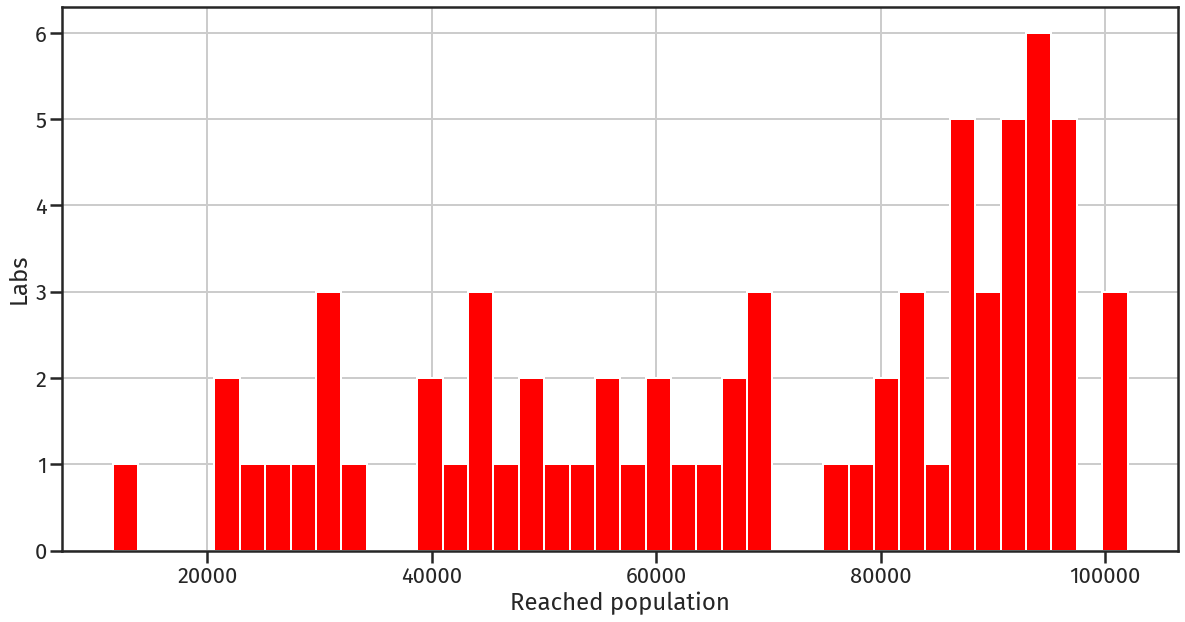

In [23]:
map_data["total_pop"].plot(kind="hist", bins=40, figsize=(20,10), color="r")
plt.grid()
plt.xlabel('Reached population')
plt.ylabel('Labs')
plt.savefig("svg" + os.sep + "city_labs_population_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_hist.png", dpi=300, bbox_inches="tight")

plot the data of the population reached by each lab

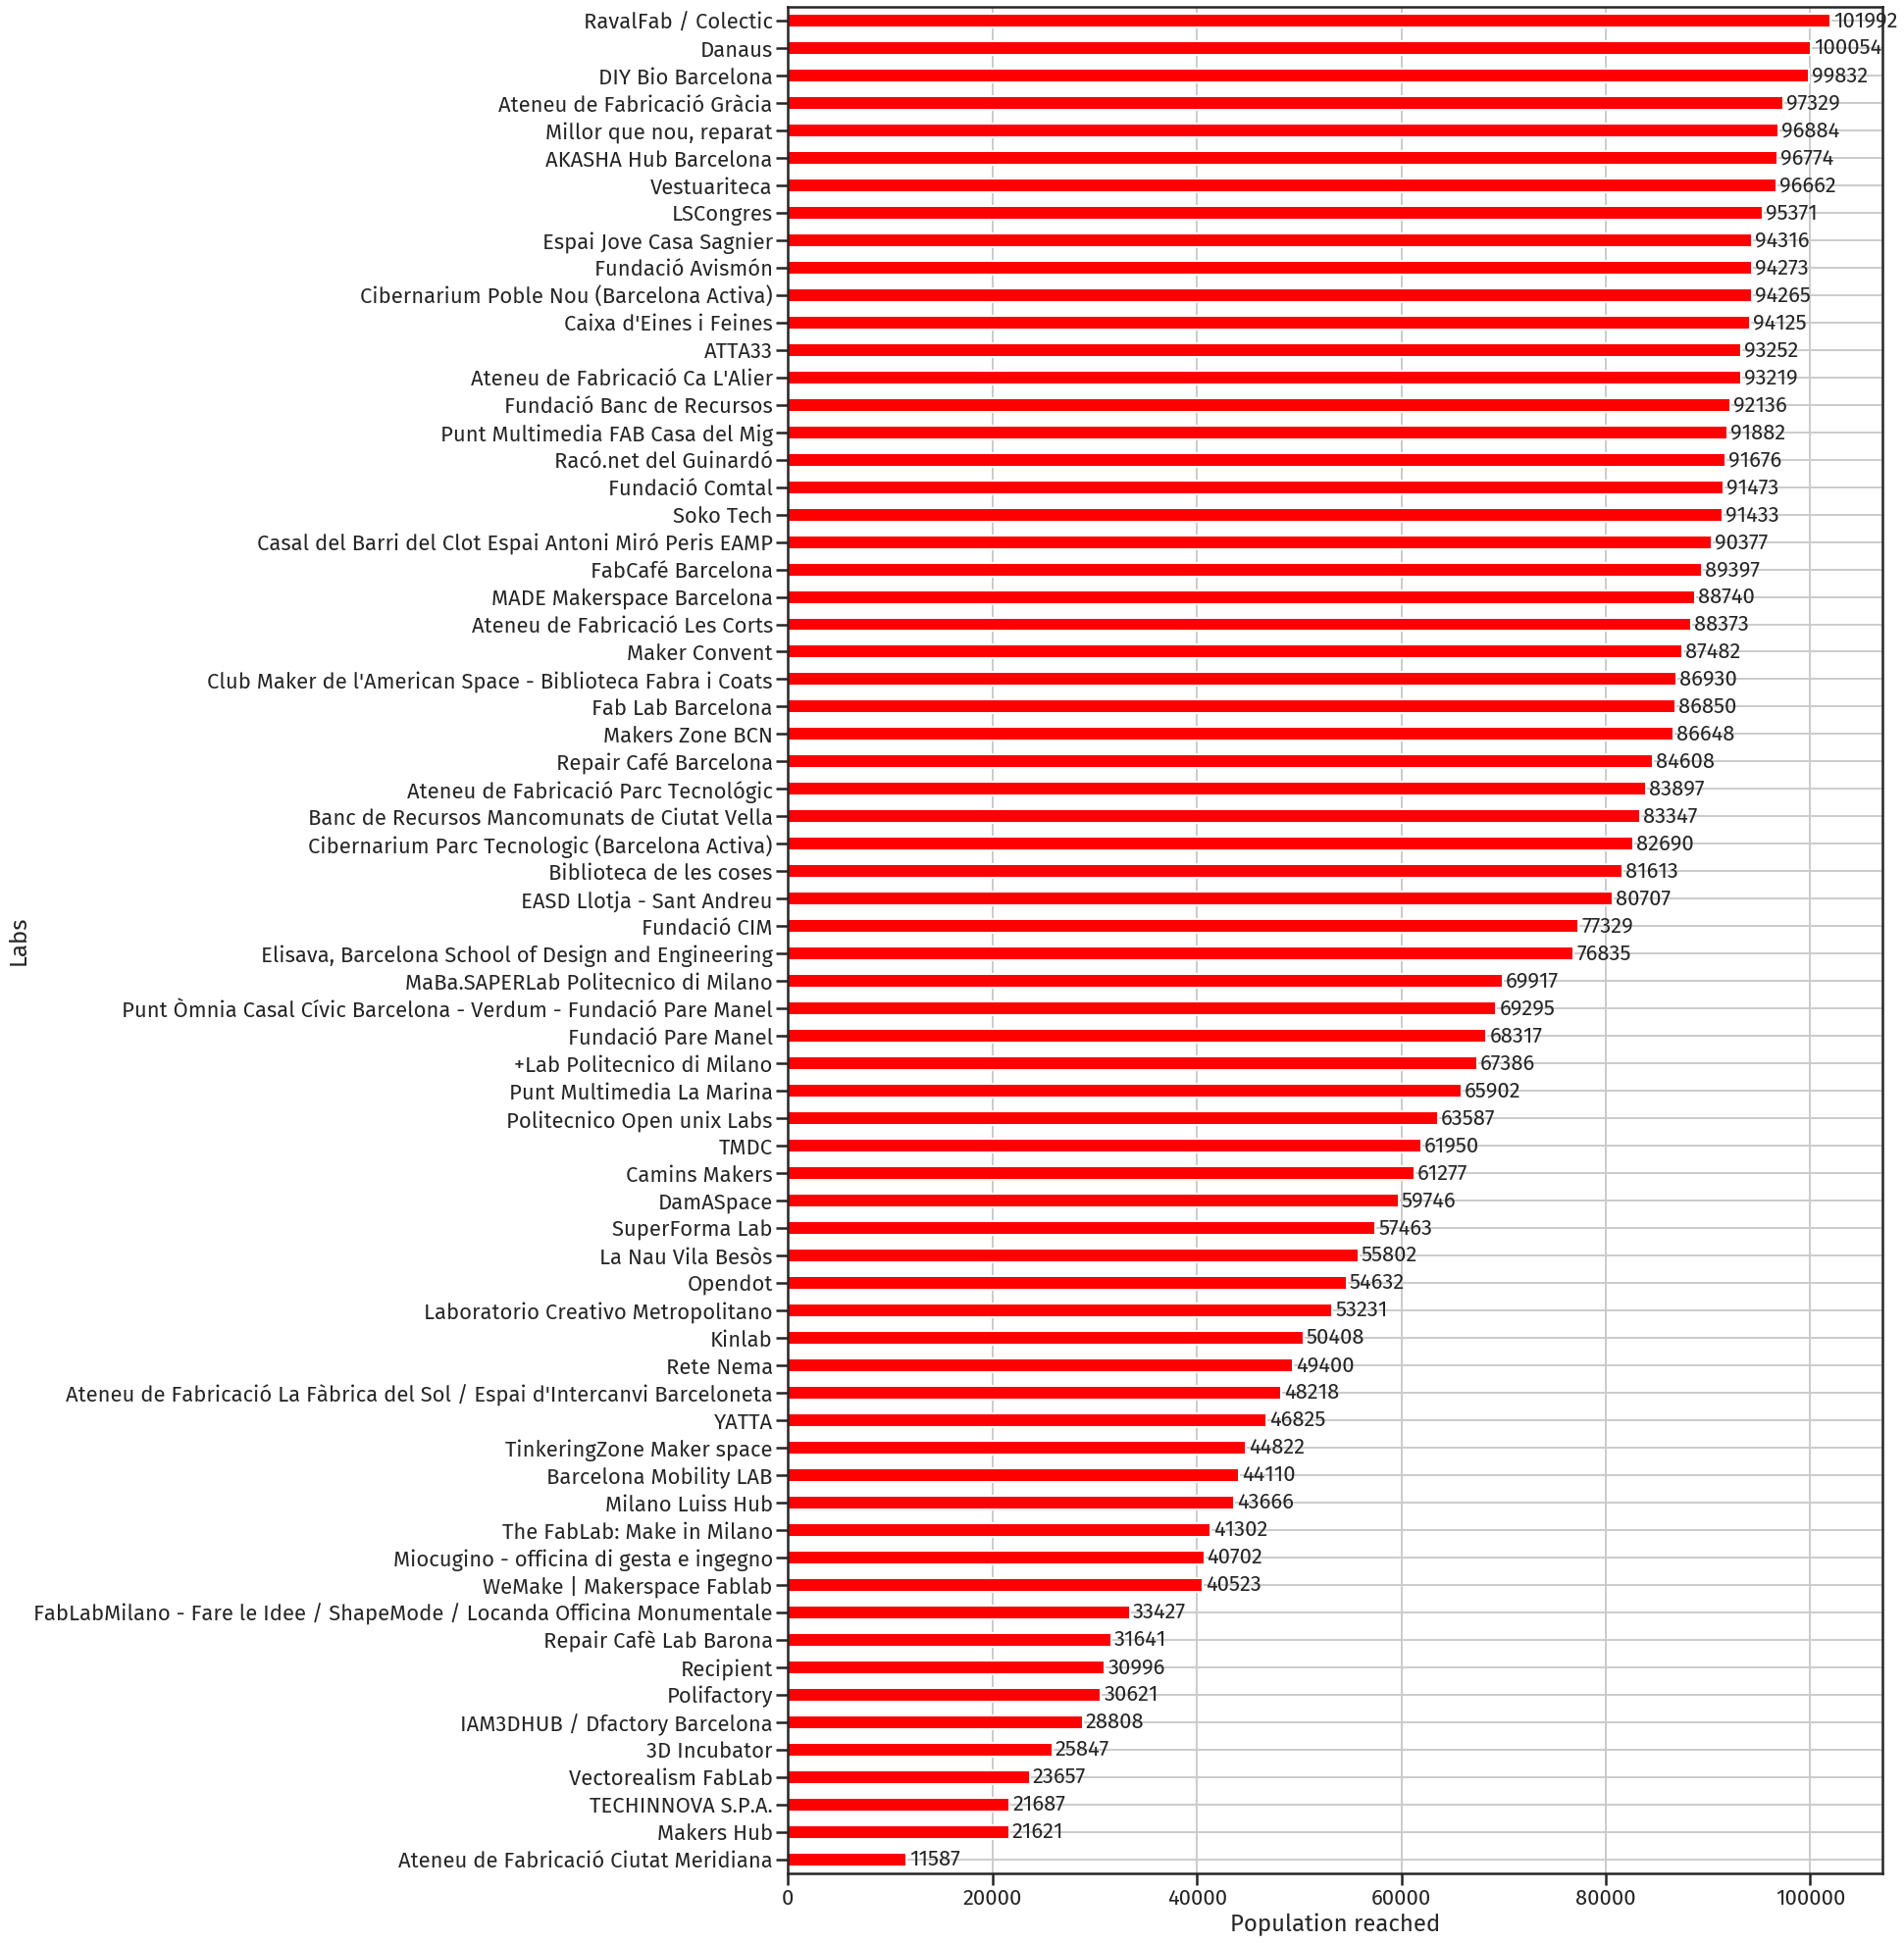

In [24]:
ax = map_data.sort_values(by=['total_pop'])['total_pop'].plot(kind="barh", figsize=(20,35), color="r")
ax.bar_label(ax.containers[0], fmt="%d", size=22, padding=3)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_population_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_bar.png", dpi=300, bbox_inches="tight")

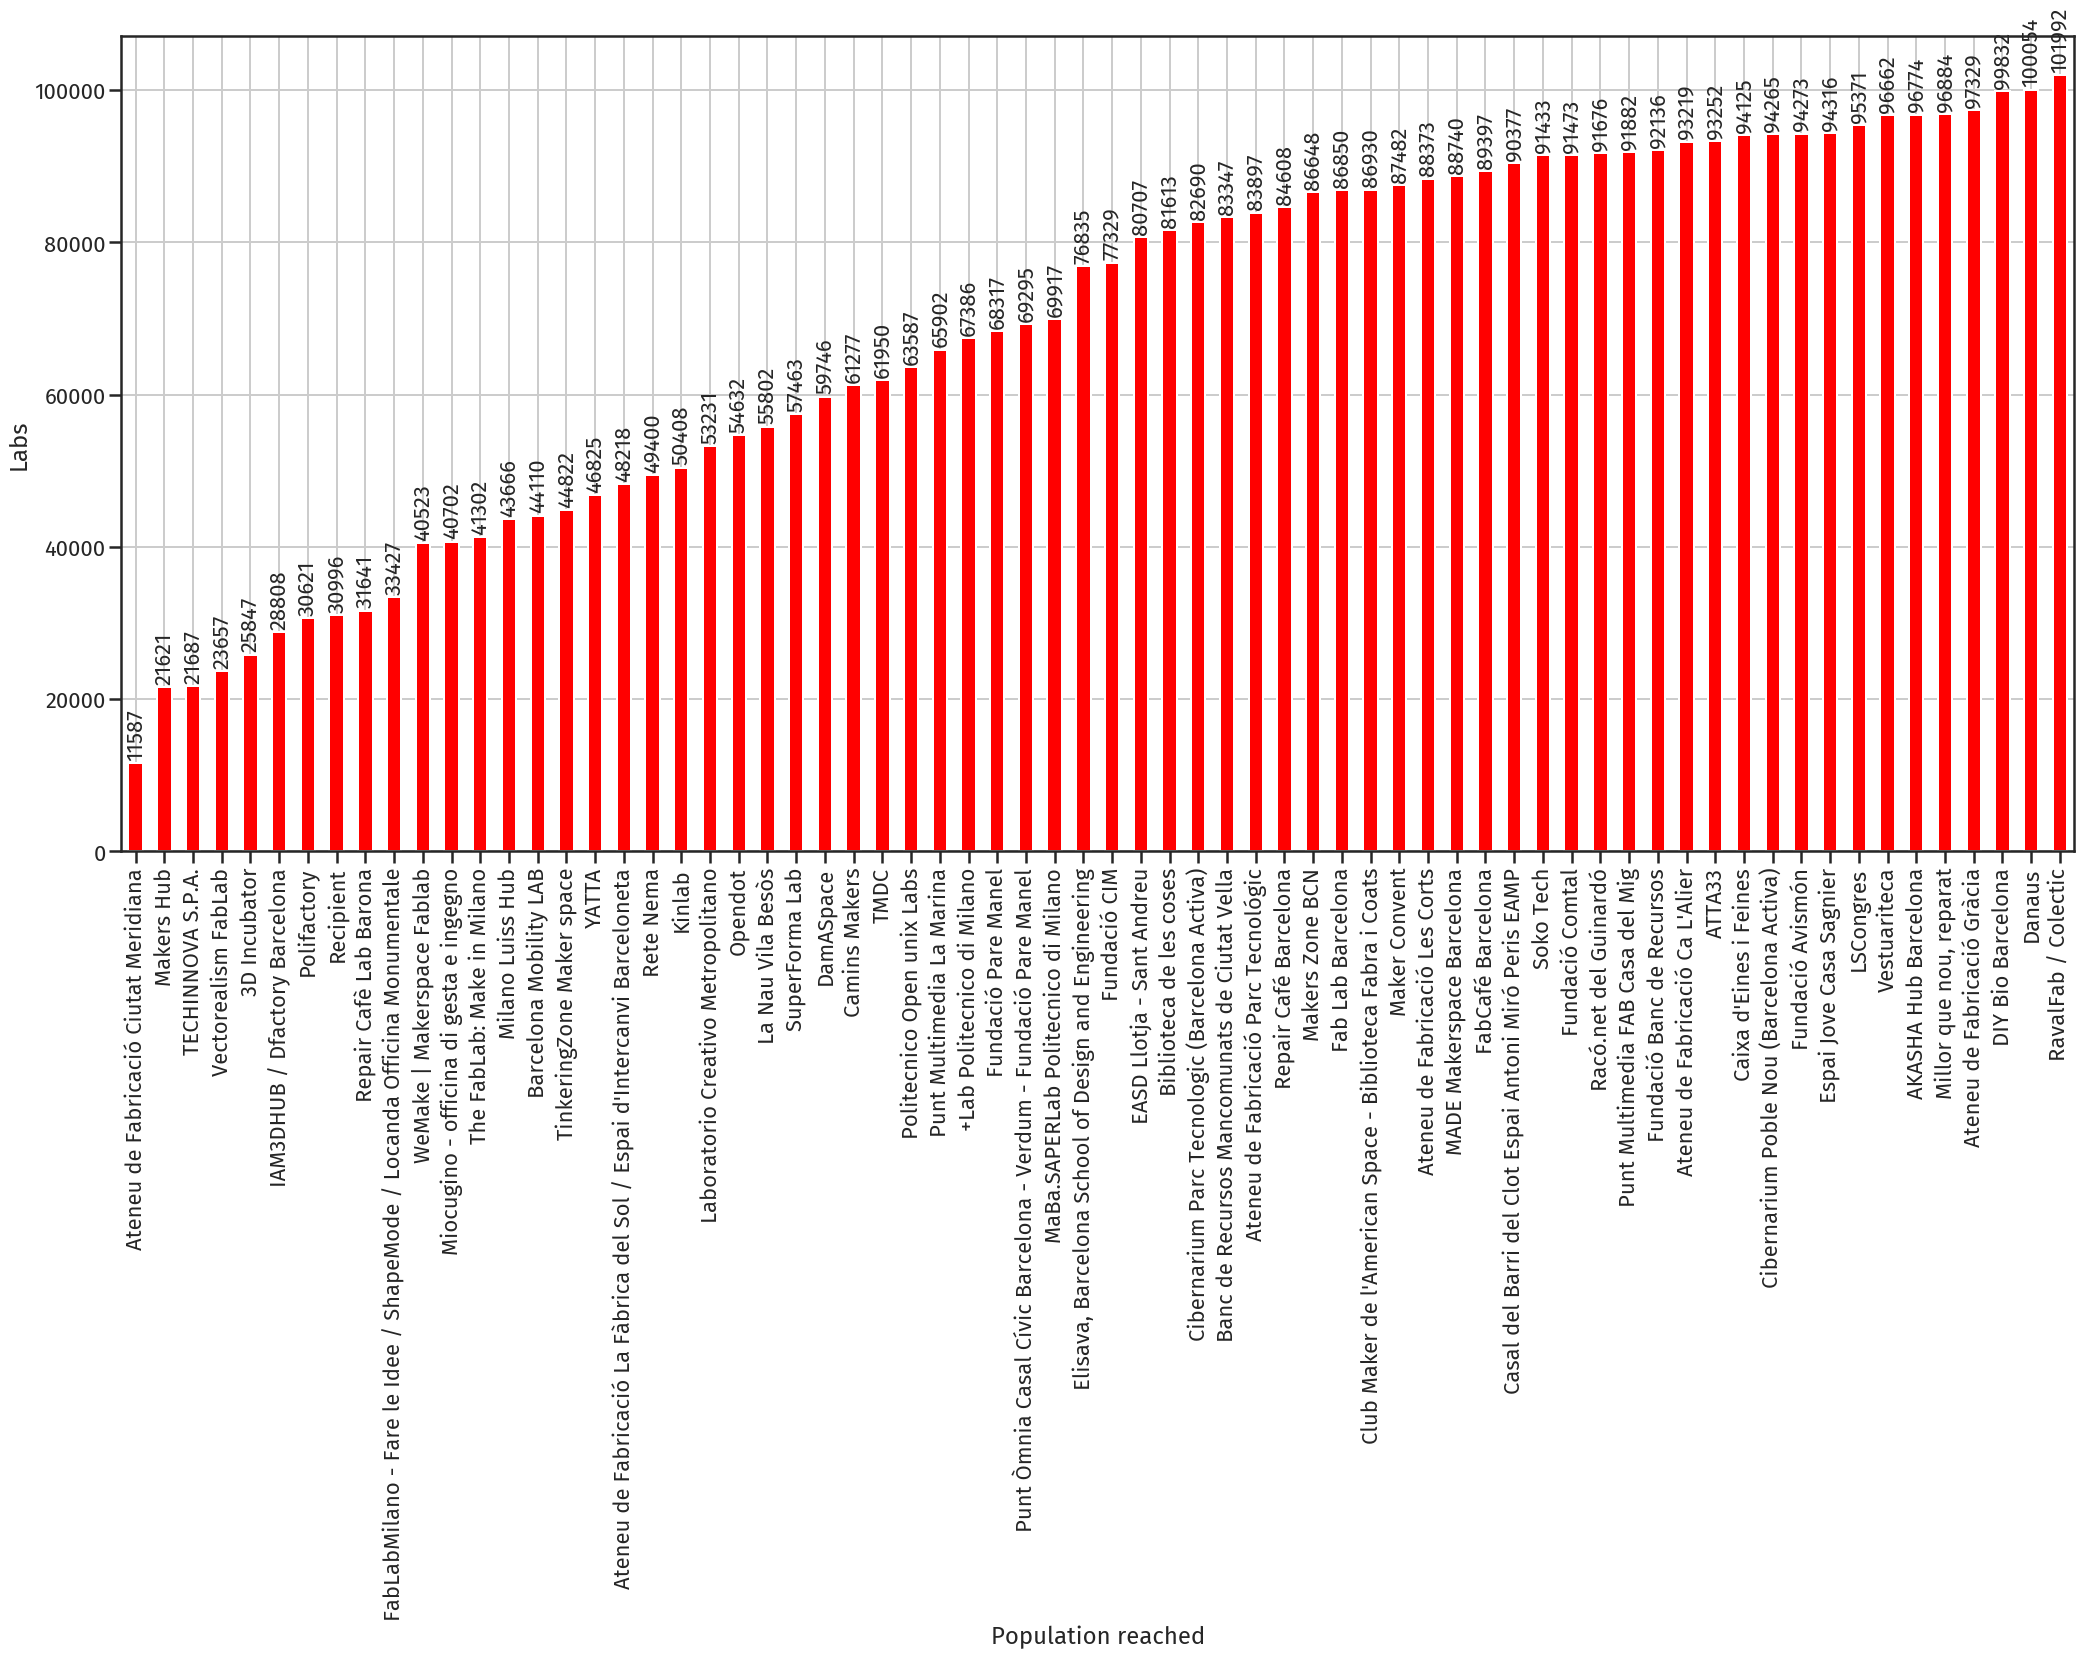

In [25]:
ax = map_data.sort_values(by=['total_pop'])['total_pop'].plot(kind="bar", figsize=(35,15), color="r")
ax.bar_label(ax.containers[0], fmt="%d", size=22, padding=3, rotation=90)
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_population_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_bar_vertical.png", dpi=300, bbox_inches="tight")

### Area reached

Plot the data

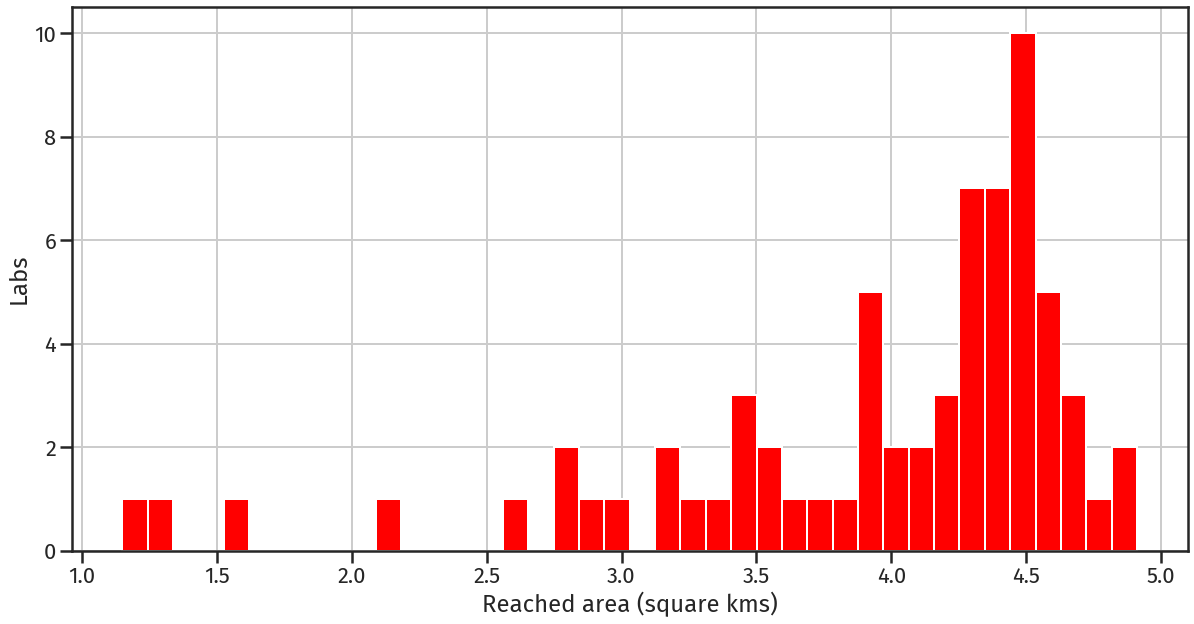

In [26]:
map_data["area"].plot(kind="hist", bins=40, figsize=(20,10), color="r")
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_hist.png", dpi=300, bbox_inches="tight")

Plot the data of the area reached by each lab

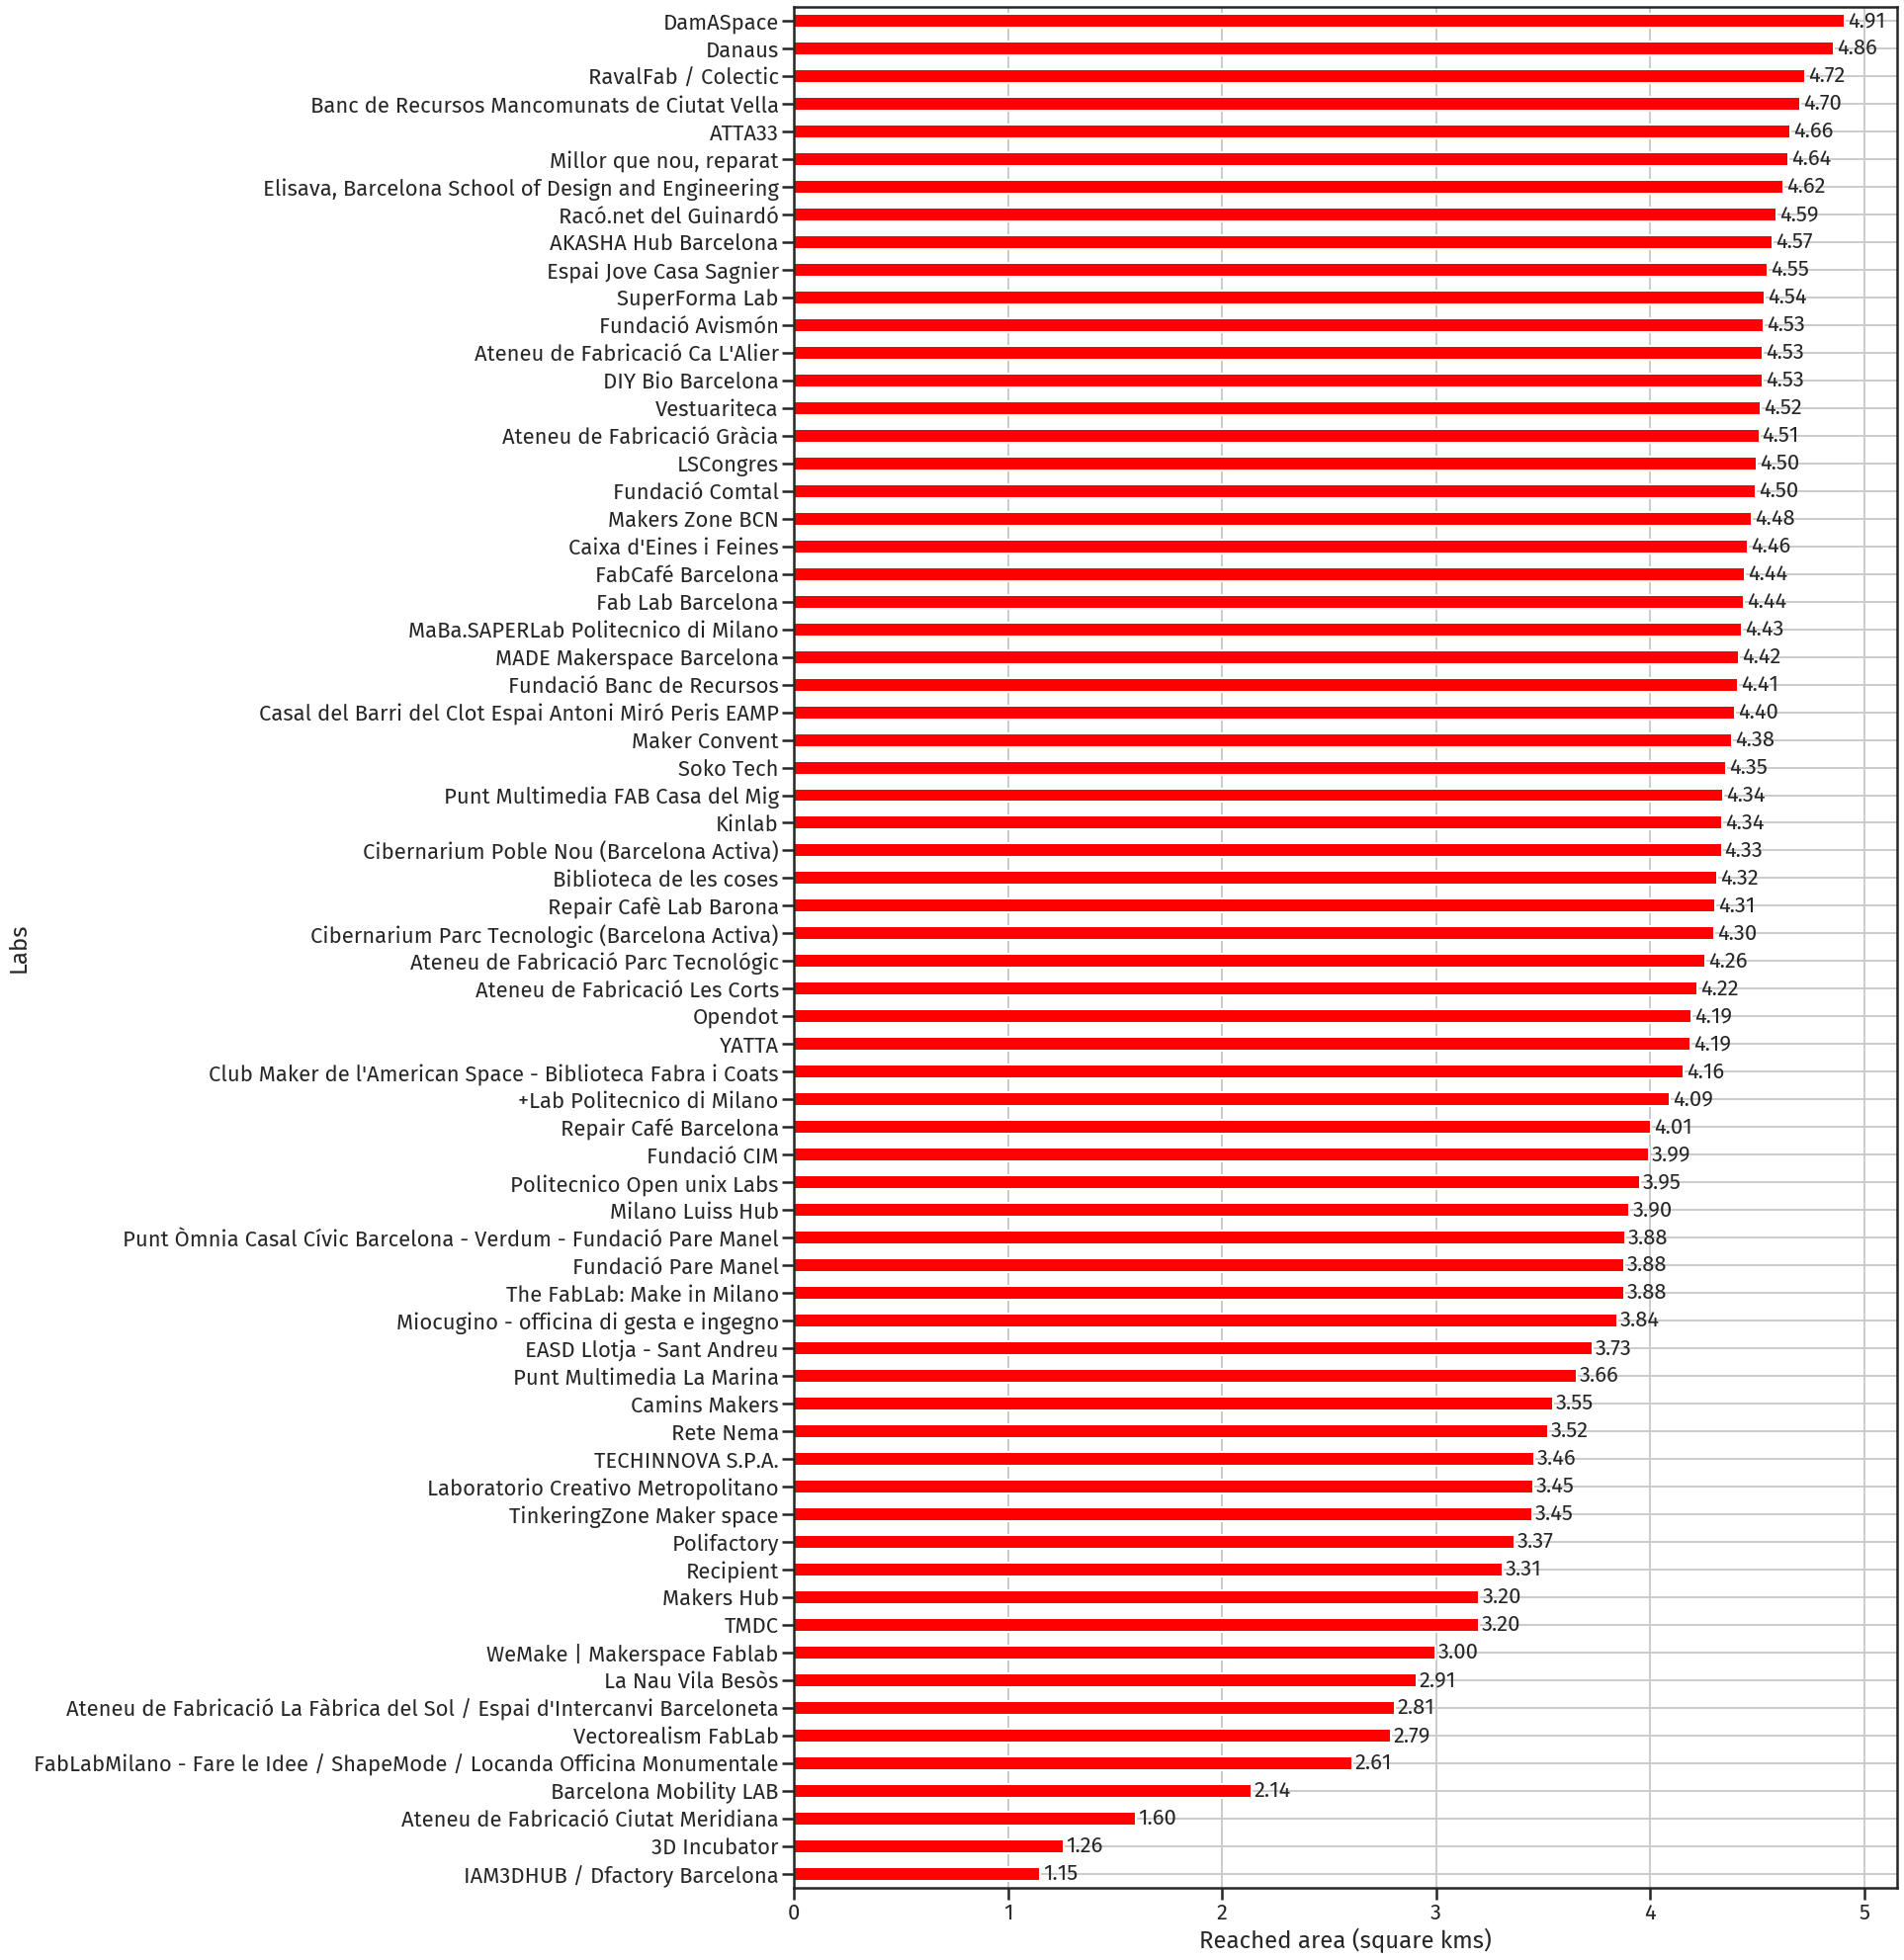

In [27]:
ax = map_data.sort_values(by=['area'])['area'].plot(kind="barh", figsize=(20,35), color="r")
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3)
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_bar.png", dpi=300, bbox_inches="tight")

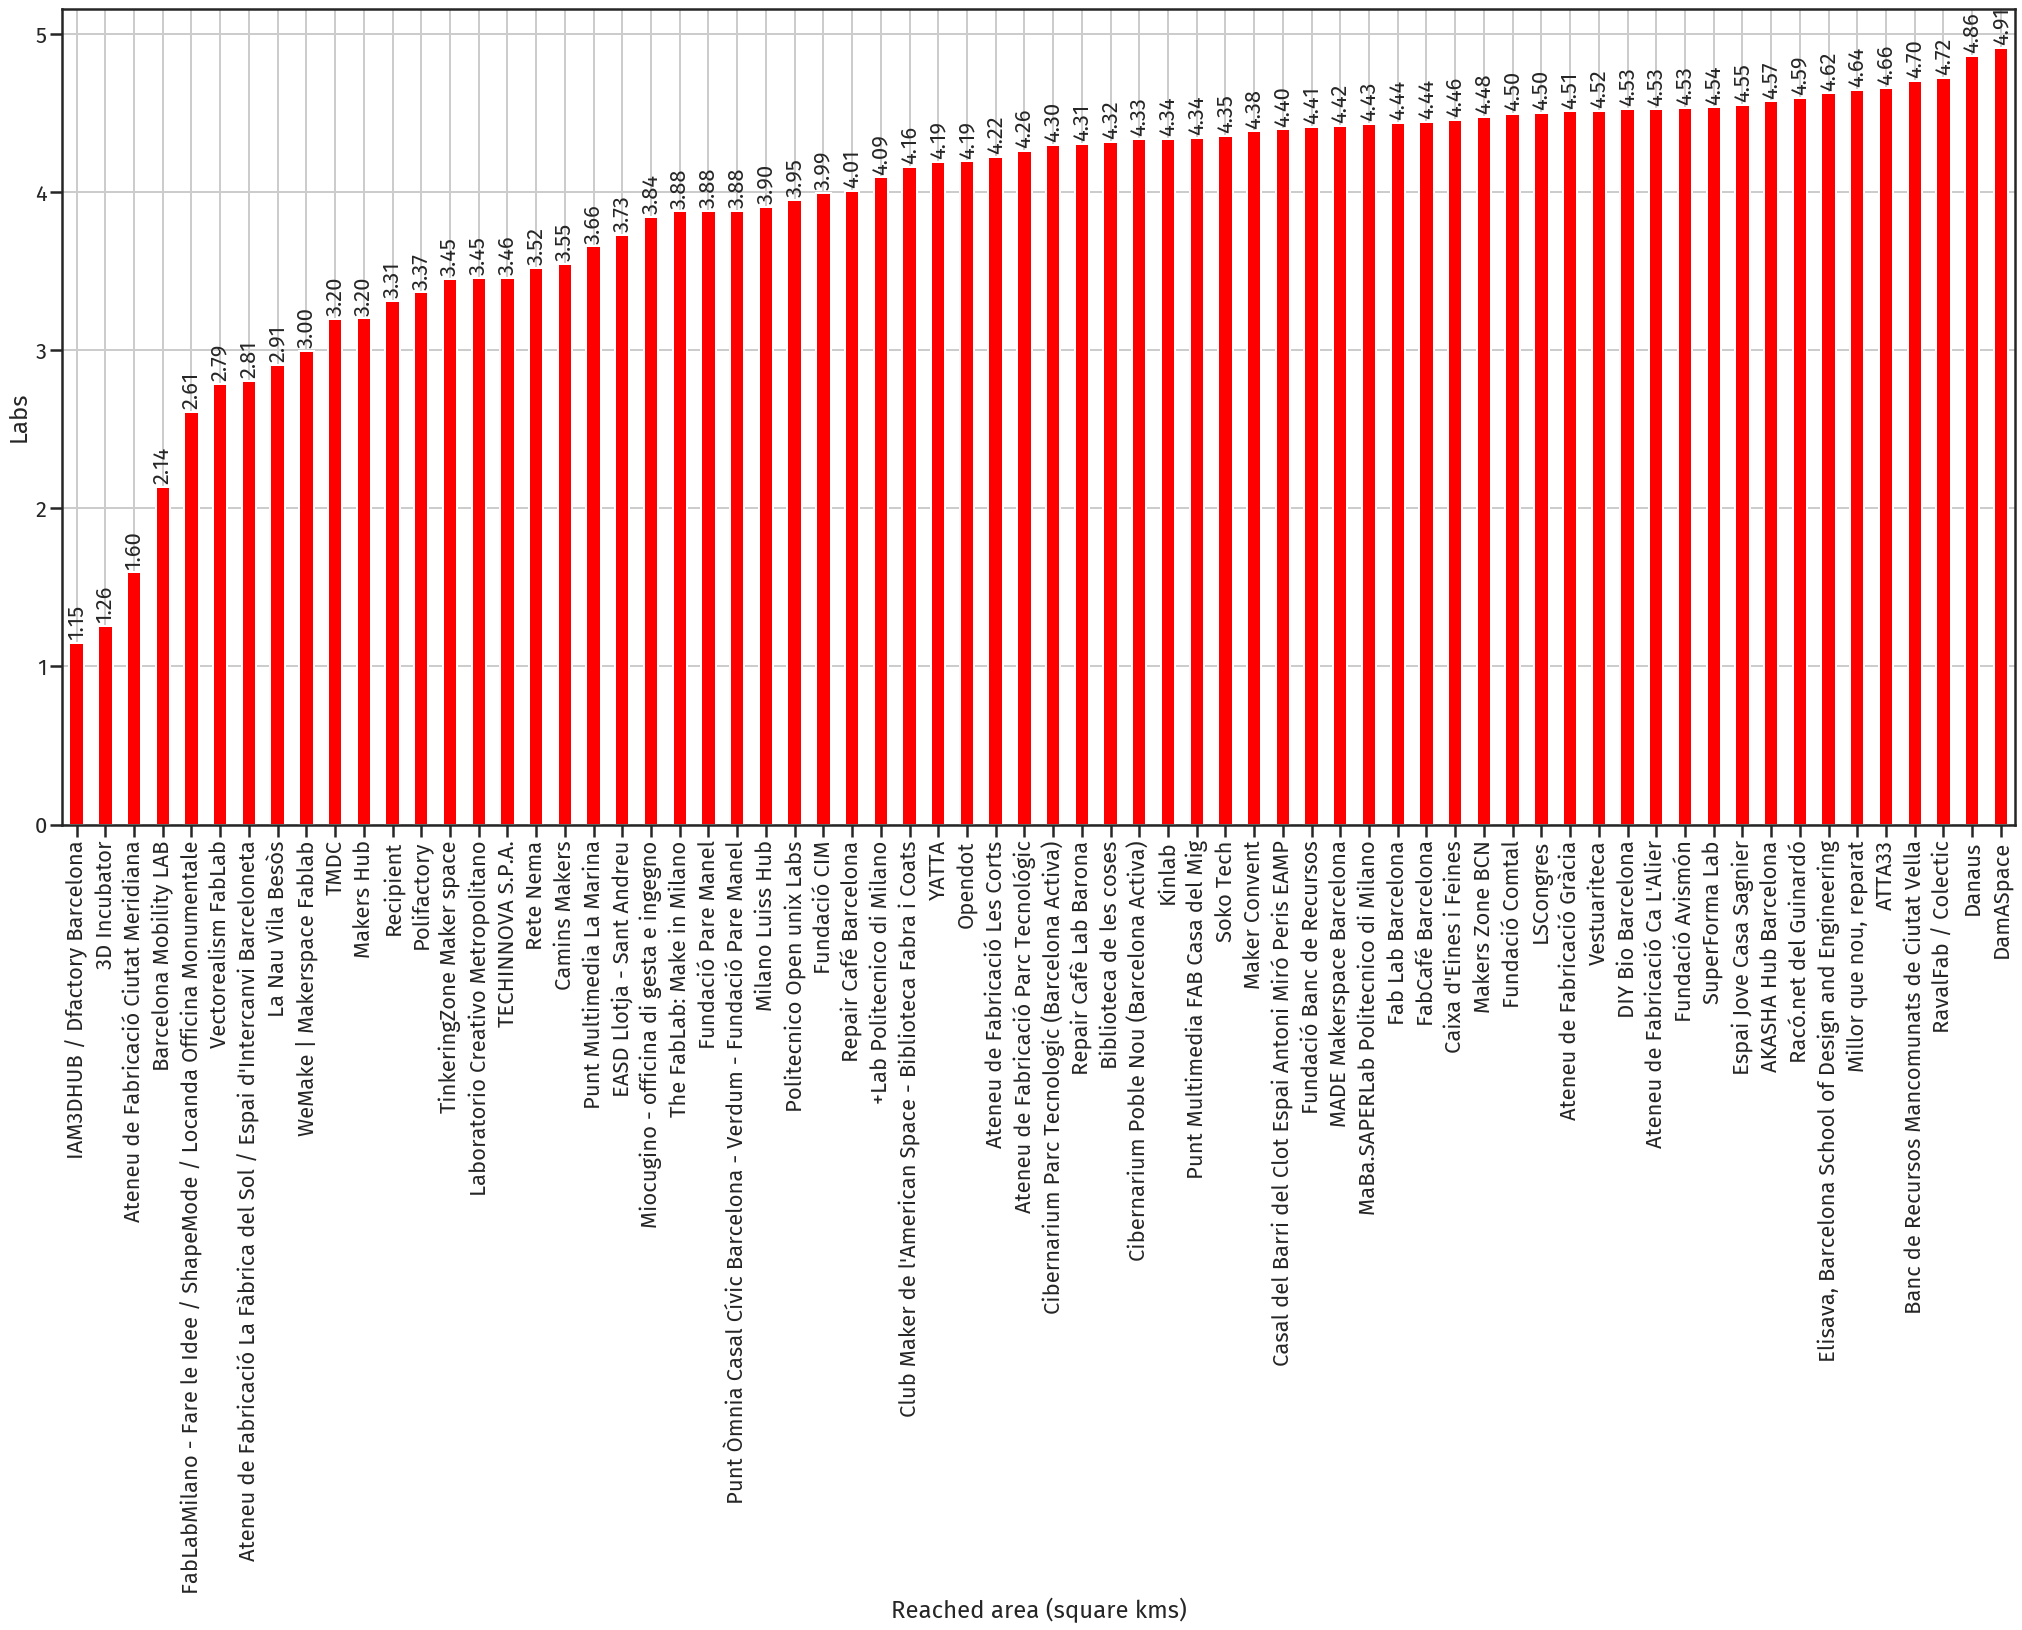

In [28]:
ax = map_data.sort_values(by=['area'])['area'].plot(kind="bar", figsize=(35,15), color="r")
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3, rotation=90)
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_bar_vertical.png", dpi=300, bbox_inches="tight")

### Reach Factor

Plot the data

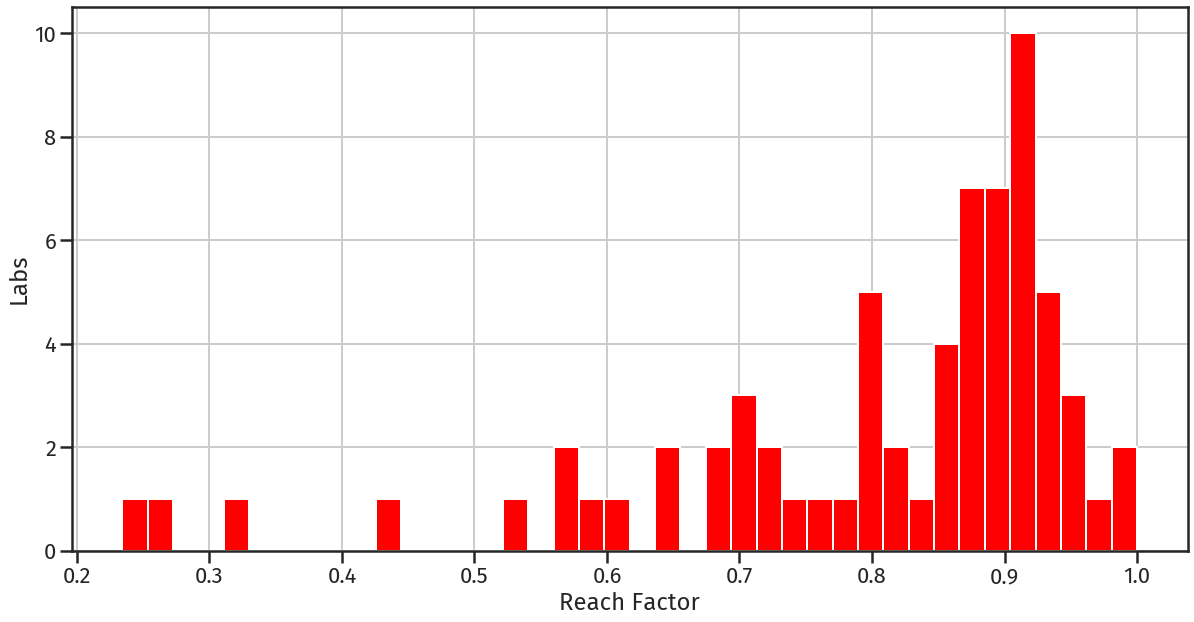

In [29]:
map_data["reachfactor"].plot(kind="hist", bins=40, figsize=(20,10), color="r")
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_hist.png", dpi=300, bbox_inches="tight")

plot the data of the reach factor for each lab

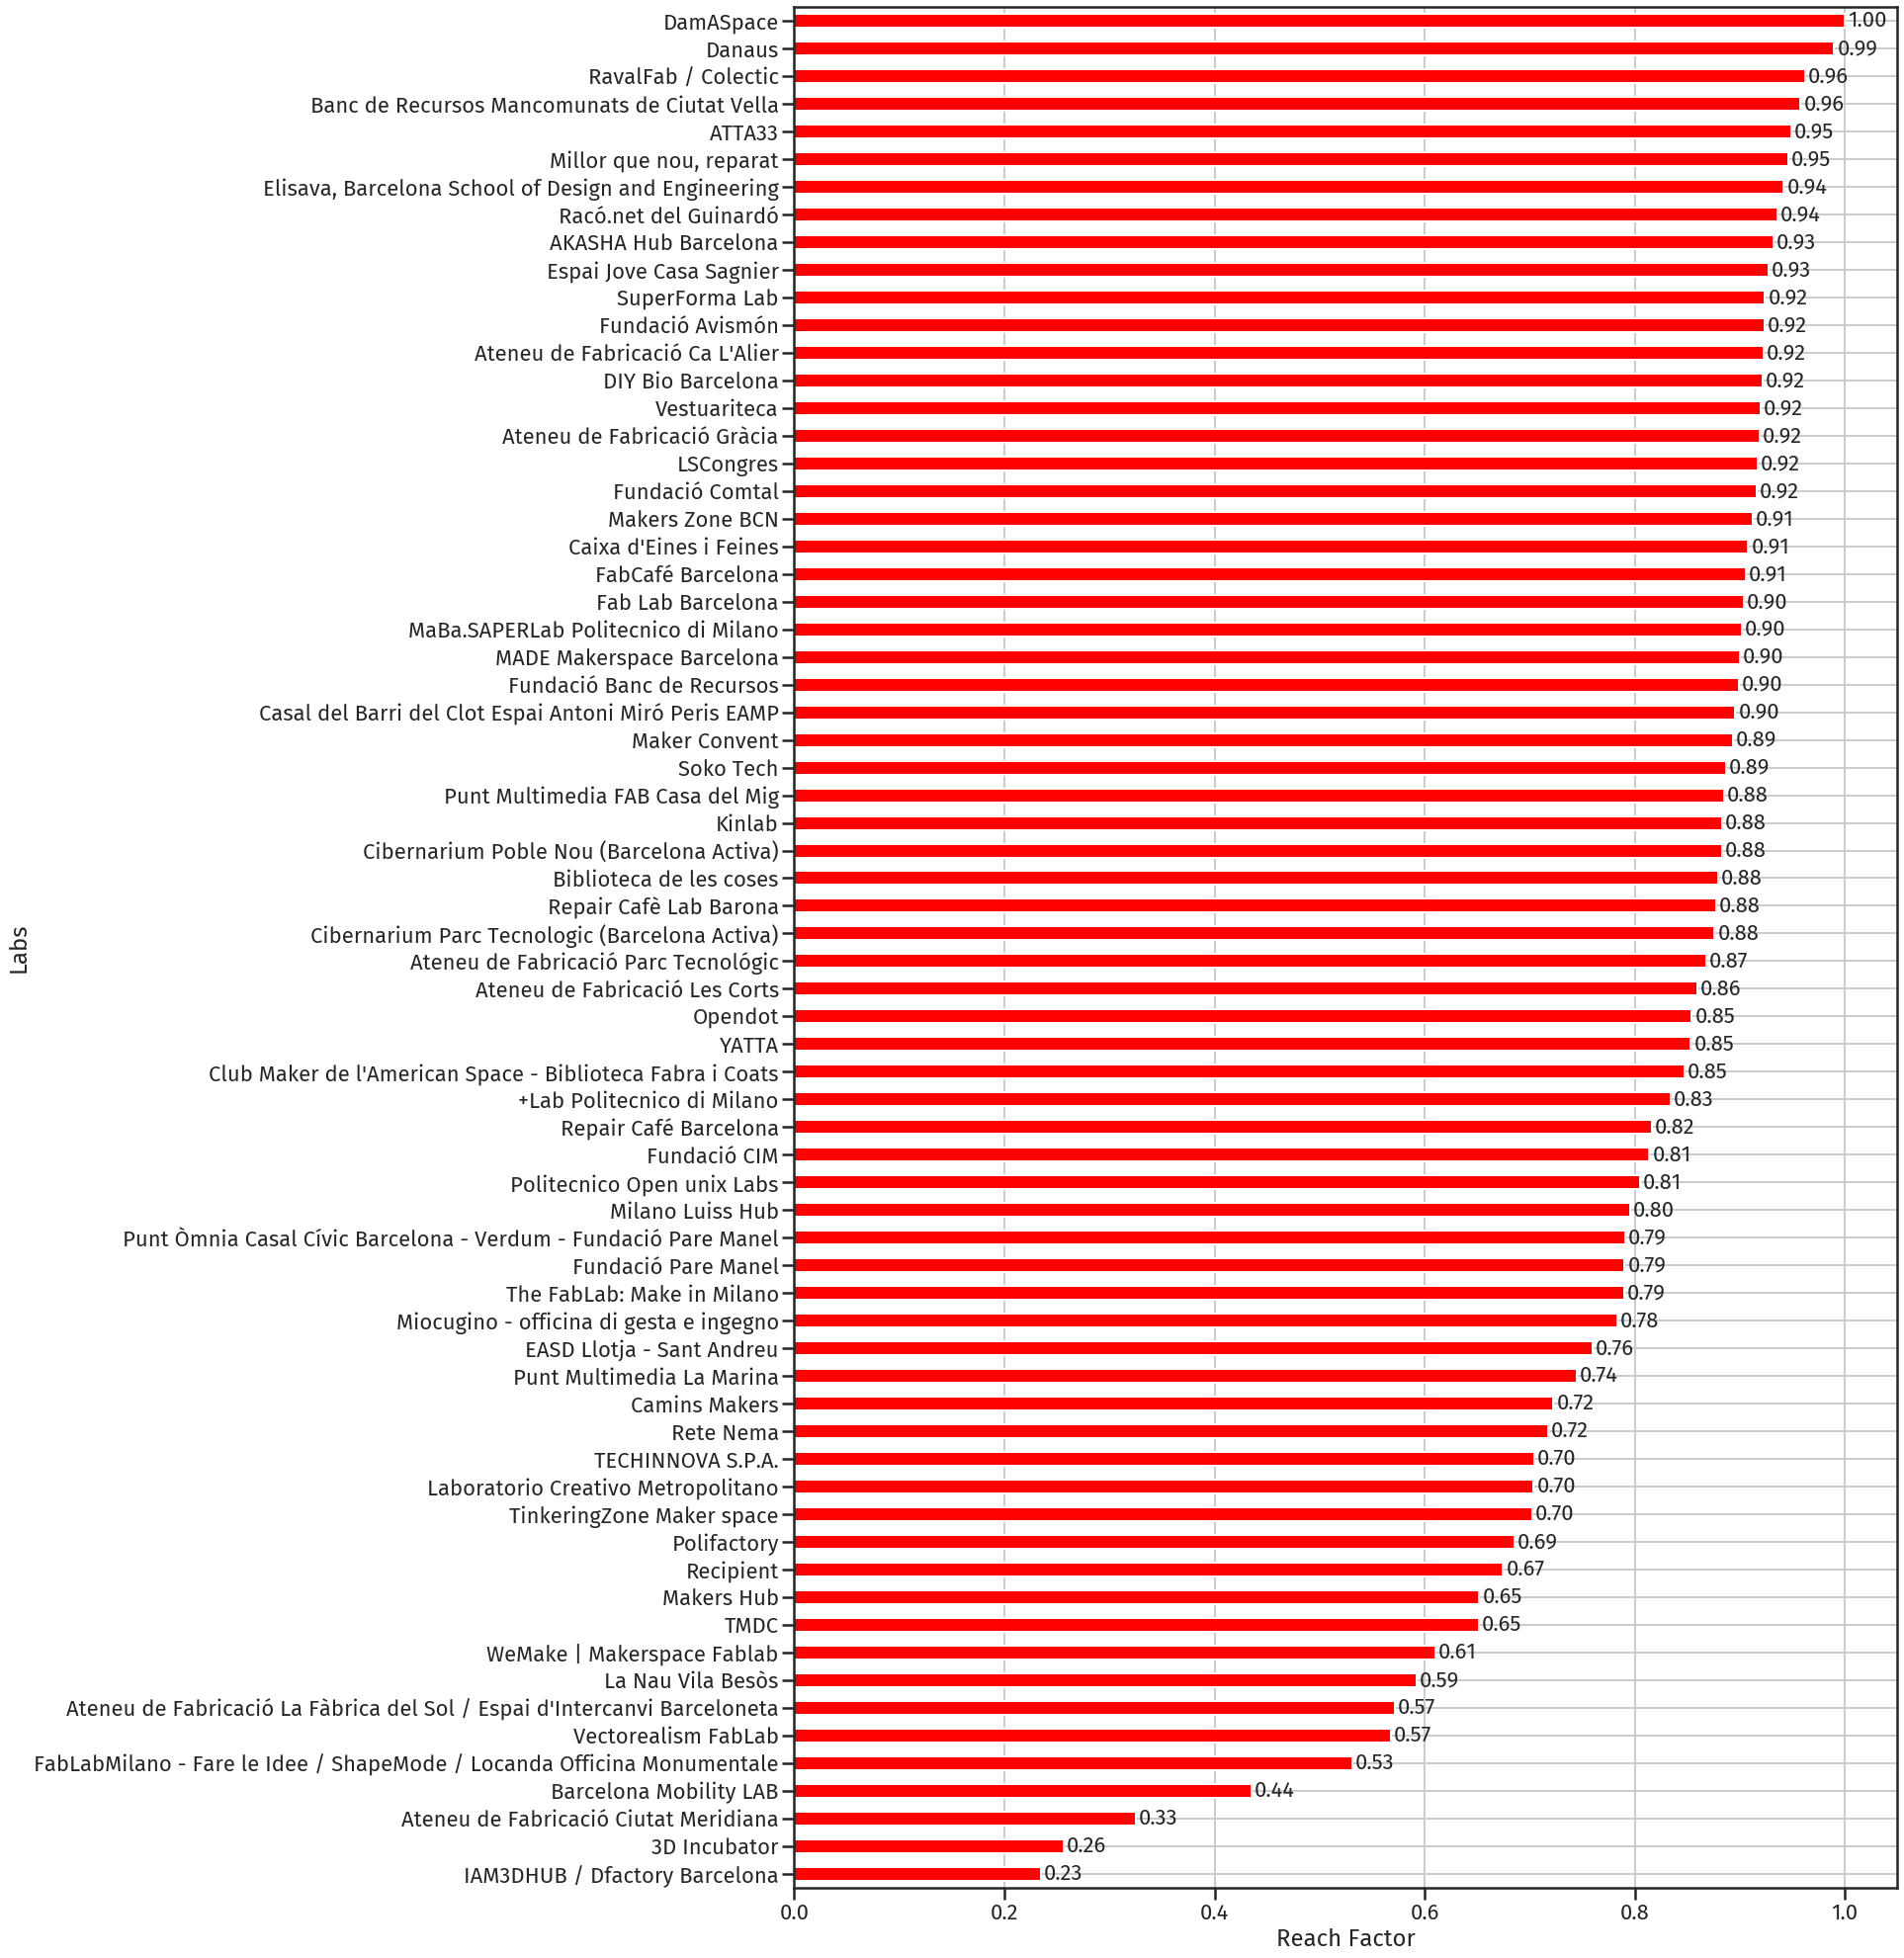

In [30]:
ax = map_data.sort_values(by=['reachfactor'])['reachfactor'].plot(kind="barh", figsize=(20,35), color="r")
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_bar.png", dpi=300, bbox_inches="tight")

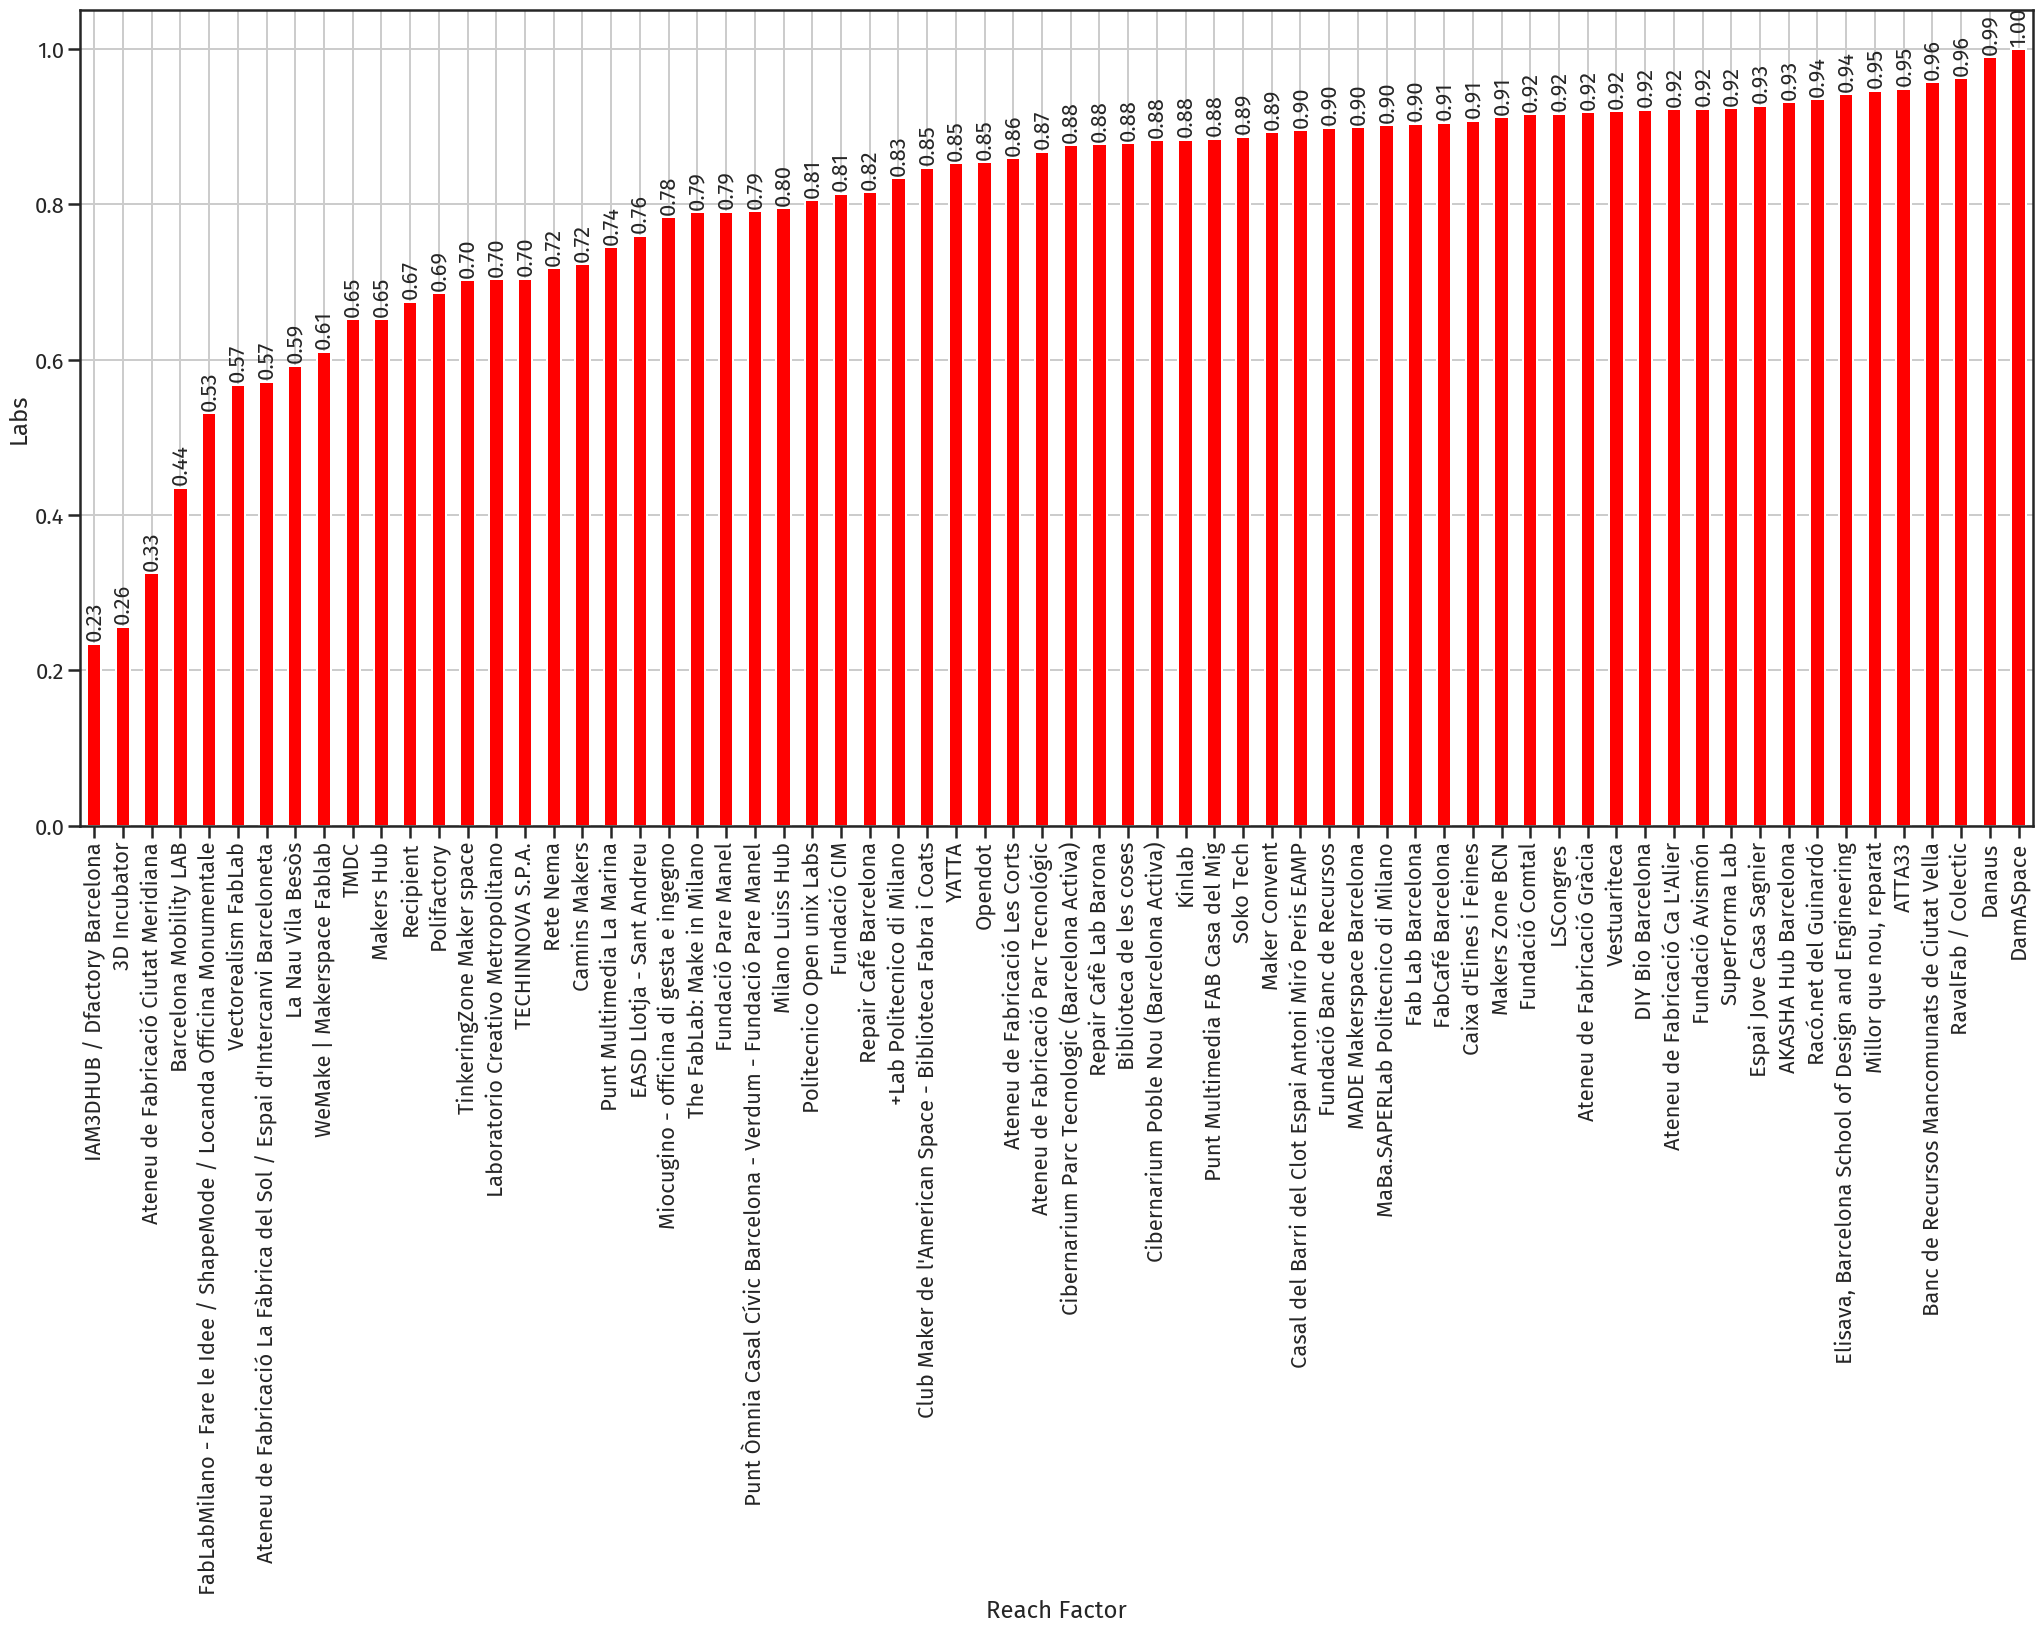

In [31]:
ax = map_data.sort_values(by=['reachfactor'])['reachfactor'].plot(kind="bar", figsize=(35,15), color="r")
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3, rotation=90)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_bar_vertical.png", dpi=300, bbox_inches="tight")

### Labs values clustered by city

In [32]:
full_map_data.groupby(["Cluster","Type"]).size()

Cluster  Type                                                                   
BCN      Ateneu de Fabricació                                                       5
         Ateneu de Fabricació / Barcelona Recircula – Tool Library / Repair Cafè    1
         Barcelona Recircula – Tool Library / Repair Cafè                           7
         City Space                                                                 5
         DIYBio Lab                                                                 1
         Fab Lab                                                                    6
         FabCafé                                                                    1
         Foundation                                                                 3
         Hackerspace                                                                2
         Incubator-Accelerator                                                      4
         Library                                           

In [33]:
full_map_data.groupby("Cluster")["total_pop"].sum()

Cluster
BCN    3703884.0
MI      977260.0
Name: total_pop, dtype: float64

In [34]:
full_map_data.groupby("Cluster")["total_pop"].describe()

count          mean           std      min      25%      50%  \
Cluster                                                                 
BCN       46.0  80519.217391  20737.864010  11587.0  76958.5  87927.5   
MI        22.0  44420.909091  14409.300069  21621.0  32087.5  44244.0   

              75%       max  
Cluster                      
BCN      93906.75  101992.0  
MI       54281.75   69917.0

In [35]:
full_map_data.groupby("Cluster")["area"].sum()

Cluster
BCN    1.849892e+08
MI     8.272315e+07
Name: area, dtype: float64

In [36]:
full_map_data.groupby("Cluster")["area"].describe()

count          mean            std         min           25%  \
Cluster                                                                 
BCN       46.0  4.021505e+06  901207.277315  1150407.81  3.910294e+06   
MI        22.0  3.760143e+06  594594.154738  2608277.99  3.385927e+06   

                 50%           75%         max  
Cluster                                         
BCN      4389960.440  4.522935e+06  4859209.70  
MI       3861309.985  4.192186e+06  4910677.26

In [37]:
full_map_data.groupby("Cluster")["reachfactor"].describe()

count      mean       std     min       25%      50%     75%     max
Cluster                                                                      
BCN       46.0  0.819263  0.183582  0.2344  0.796625  0.89435  0.9214  0.9899
MI        22.0  0.765986  0.121092  0.5314  0.689800  0.78660  0.8540  1.0000

plot the data

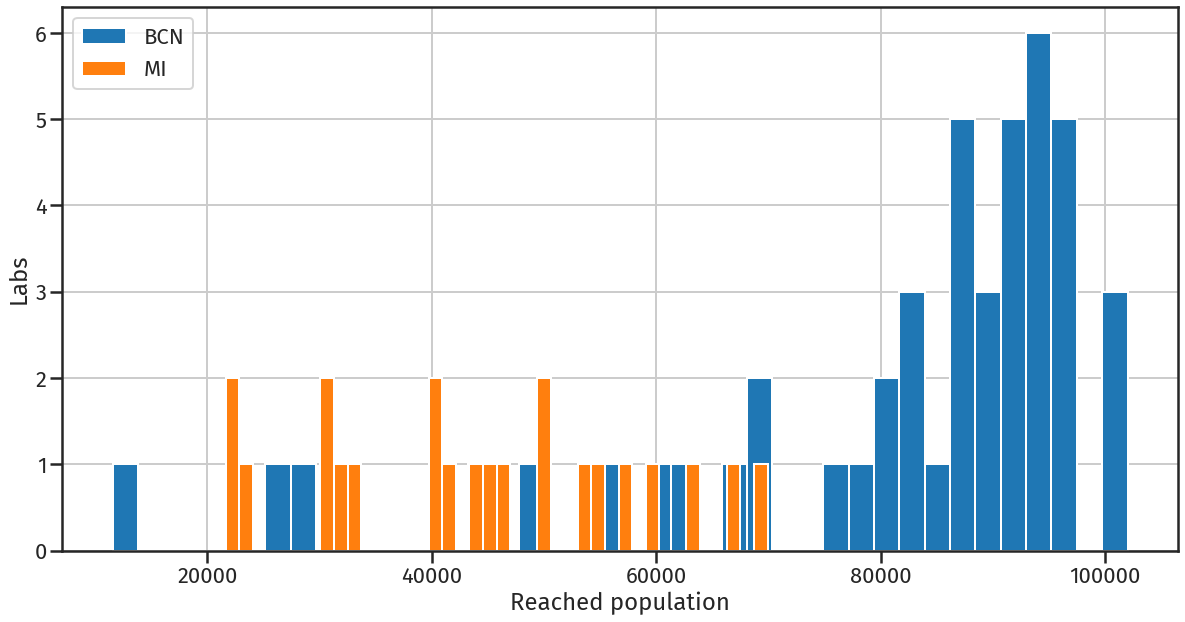

In [38]:
full_map_data.groupby("Cluster")["total_pop"].plot(kind="hist", bins=40, figsize=(20,10), legend=True)
plt.xlabel('Reached population')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_population_grouped_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_grouped_hist.png", dpi=300, bbox_inches="tight")

plot the data for each lab

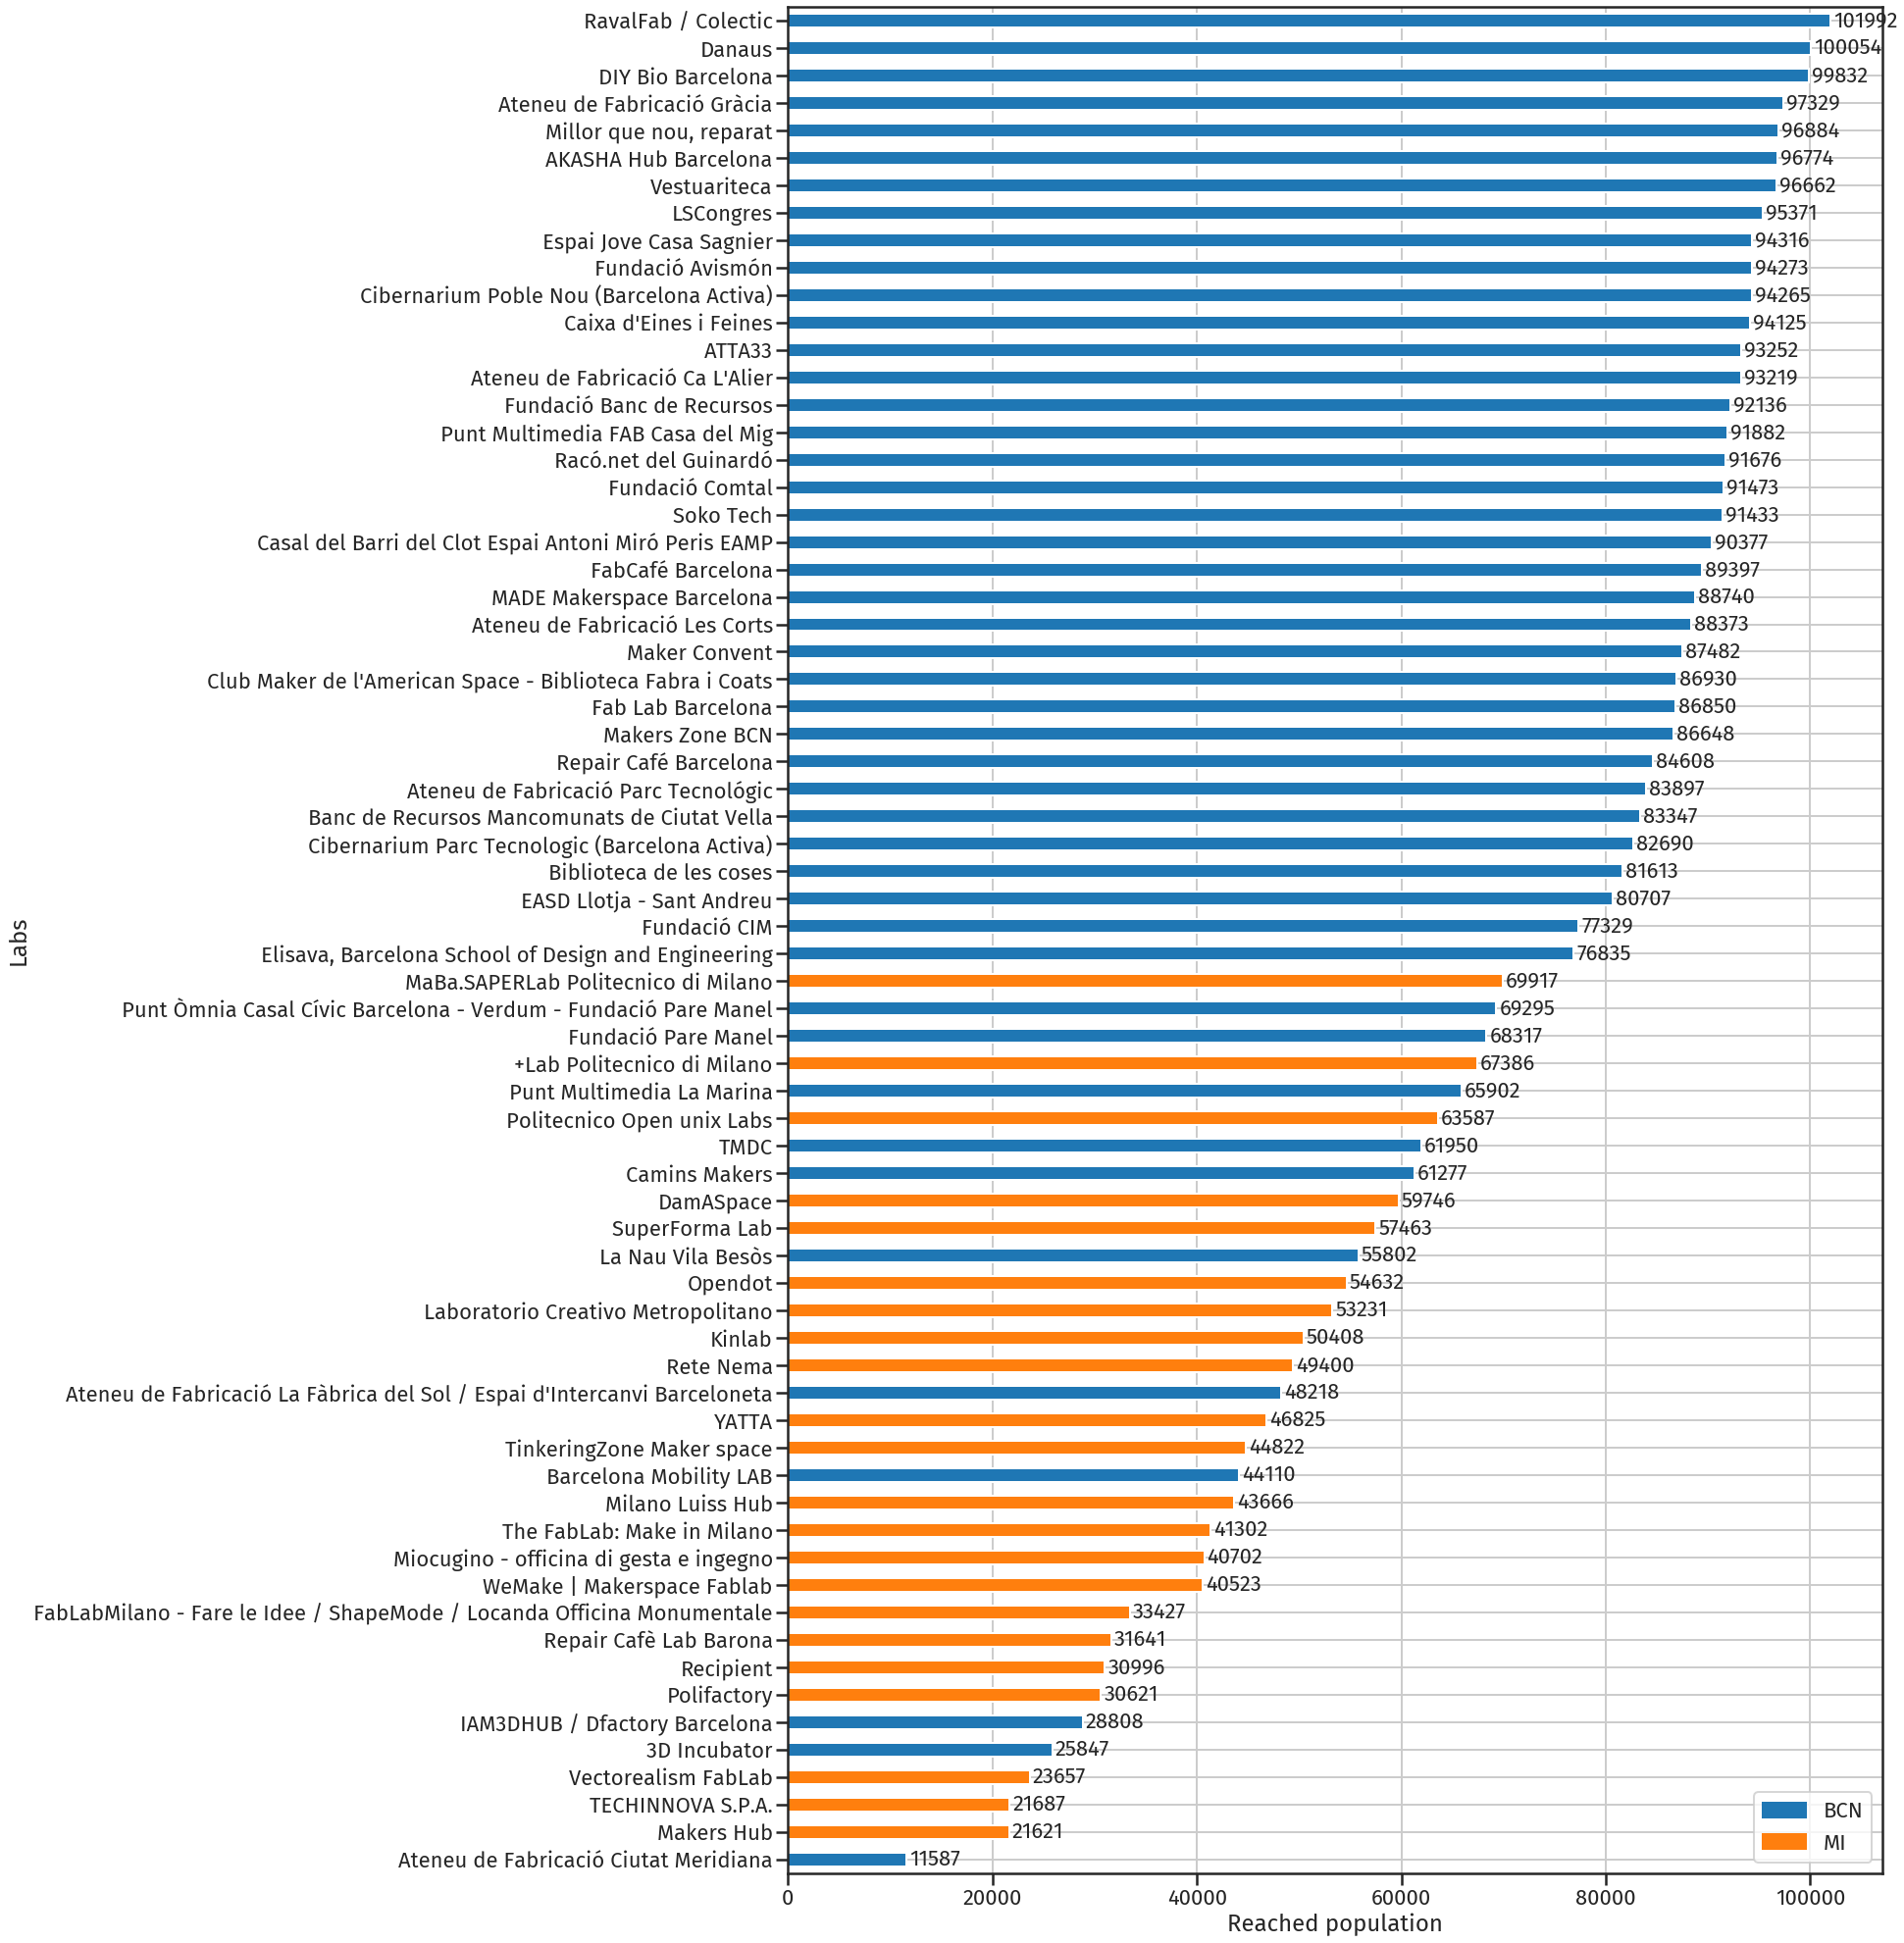

In [39]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['total_pop'])['total_pop'].plot(kind='barh', color=[colors[i] for i in full_map_data.sort_values(by=['total_pop'])['Cluster']], figsize=(20,35), legend=True)
ax.bar_label(ax.containers[0], fmt="%d", size=22, padding=3)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reached population')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_population_grouped_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_grouped_bar.png", dpi=300, bbox_inches="tight")

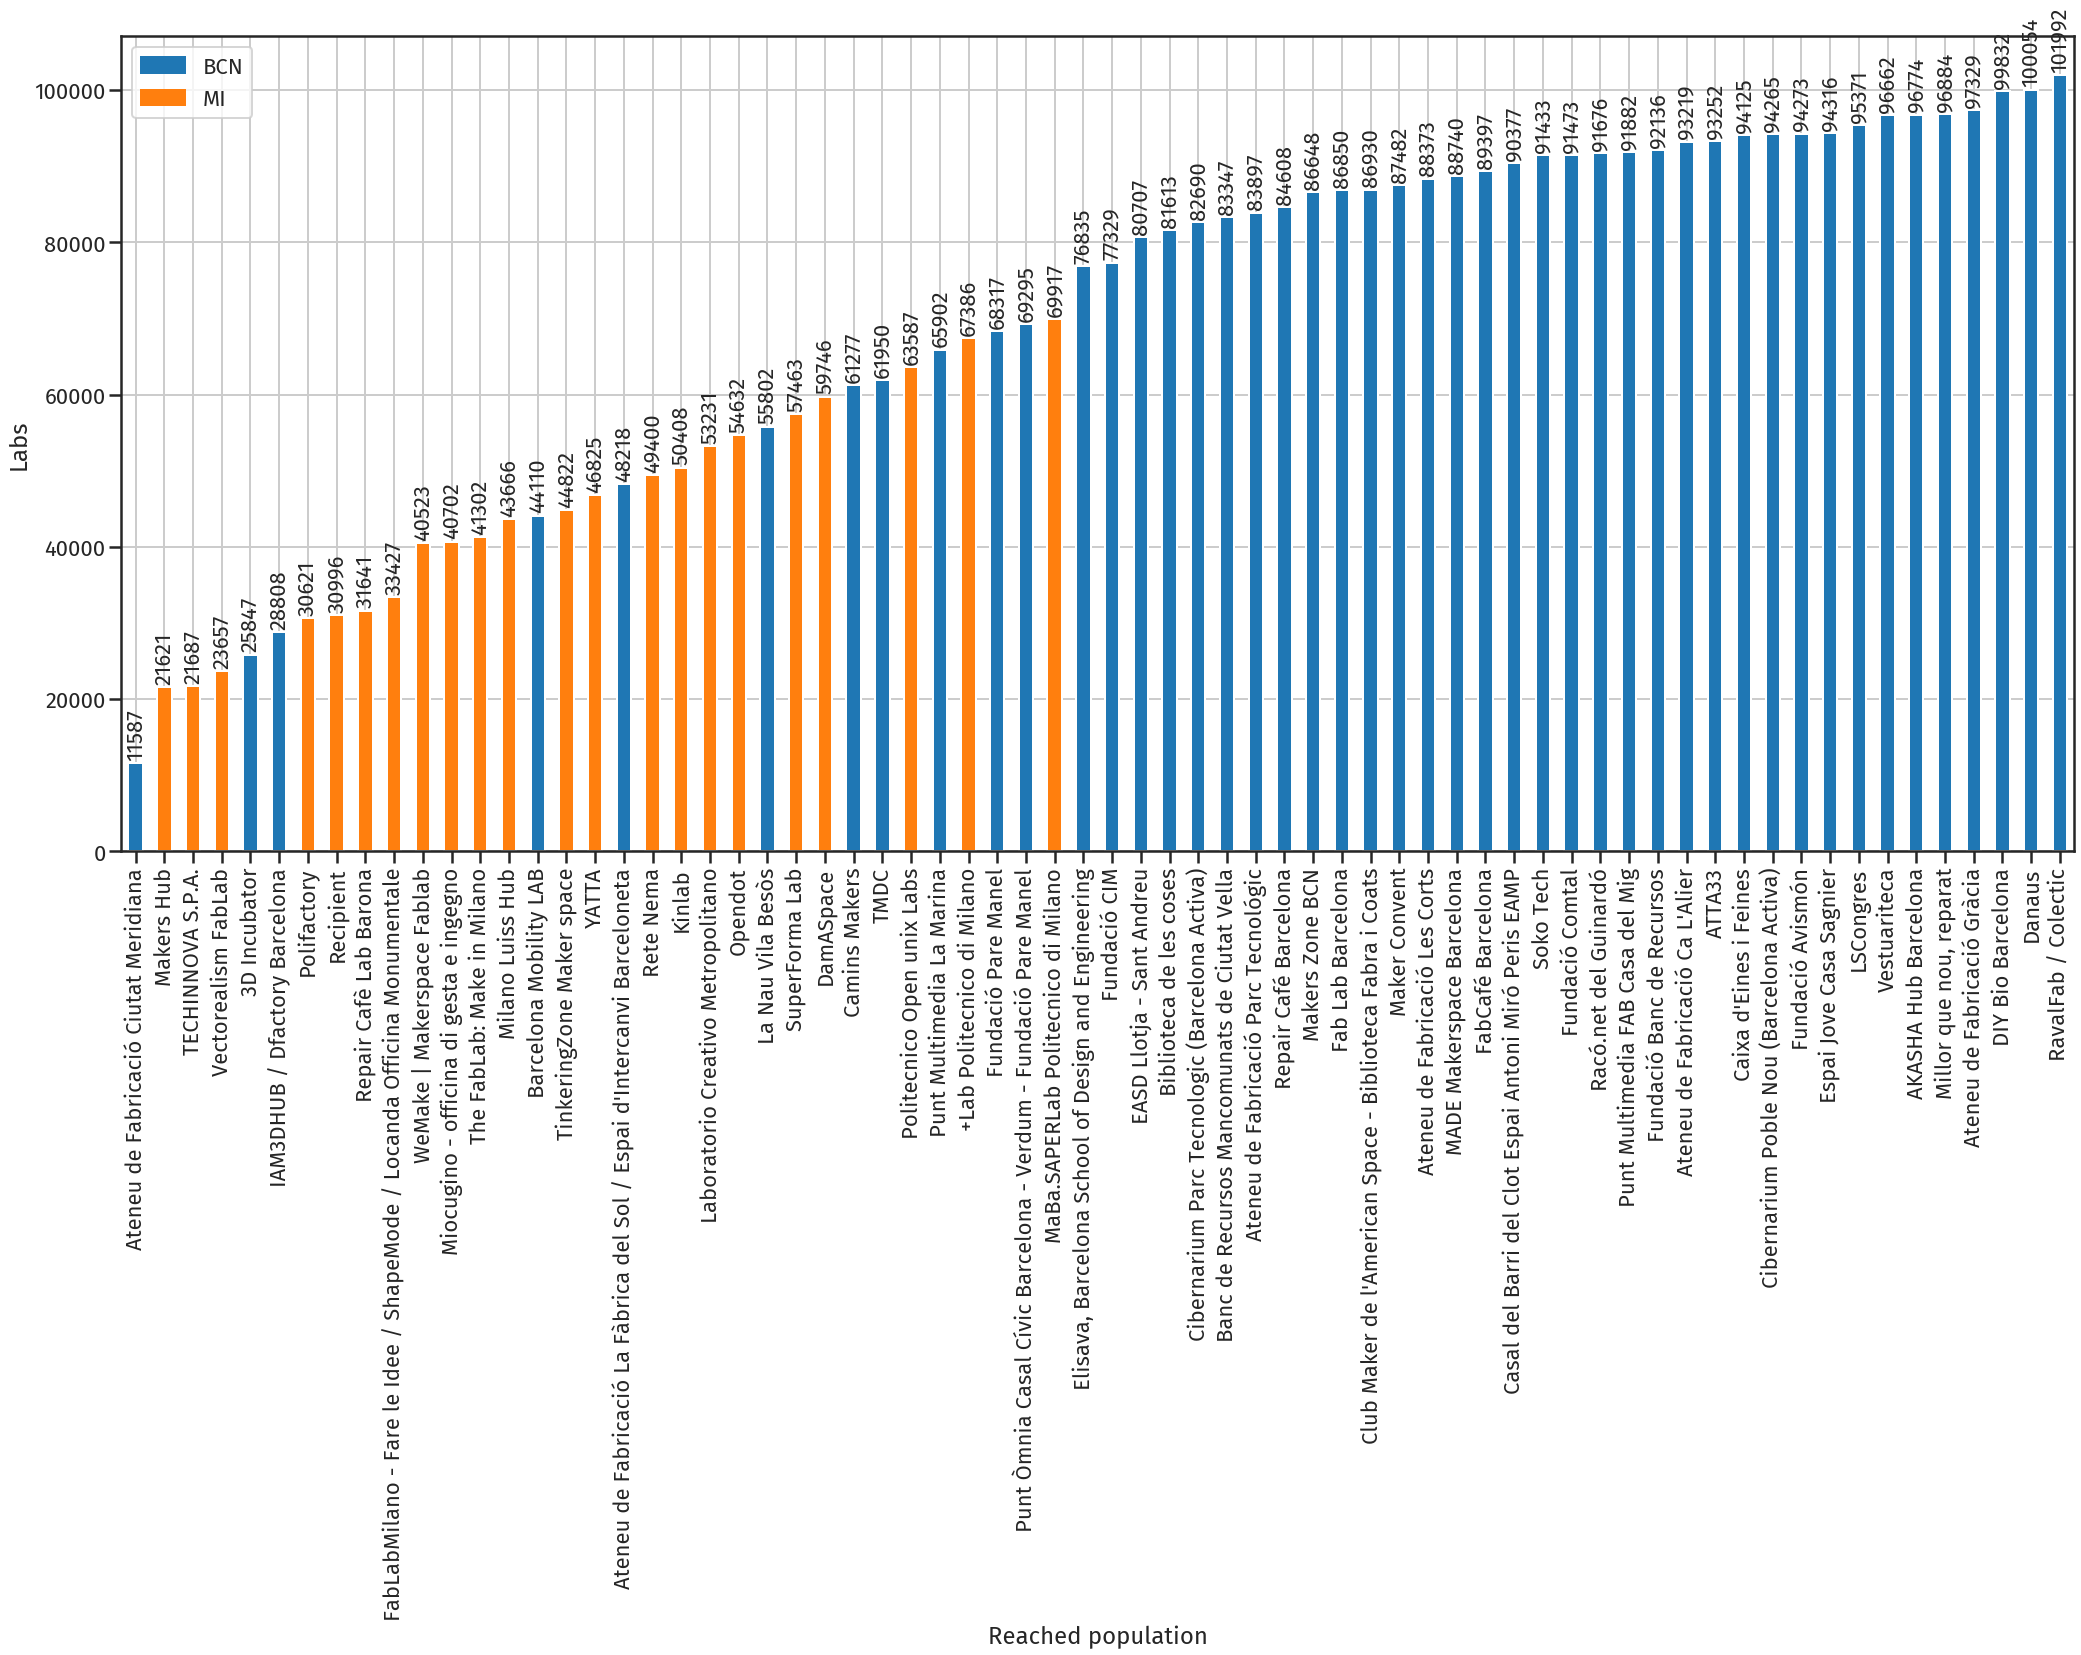

In [40]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['total_pop'])['total_pop'].plot(kind='bar', color=[colors[i] for i in full_map_data.sort_values(by=['total_pop'])['Cluster']], figsize=(35,15), legend=True)
ax.bar_label(ax.containers[0], fmt="%d", size=22, padding=3, rotation=90)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reached population')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_population_grouped_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_population_grouped_bar_vertical.png", dpi=300, bbox_inches="tight")

plot the data

In [41]:
full_map_data["area"] = full_map_data["area"].divide(1000000)

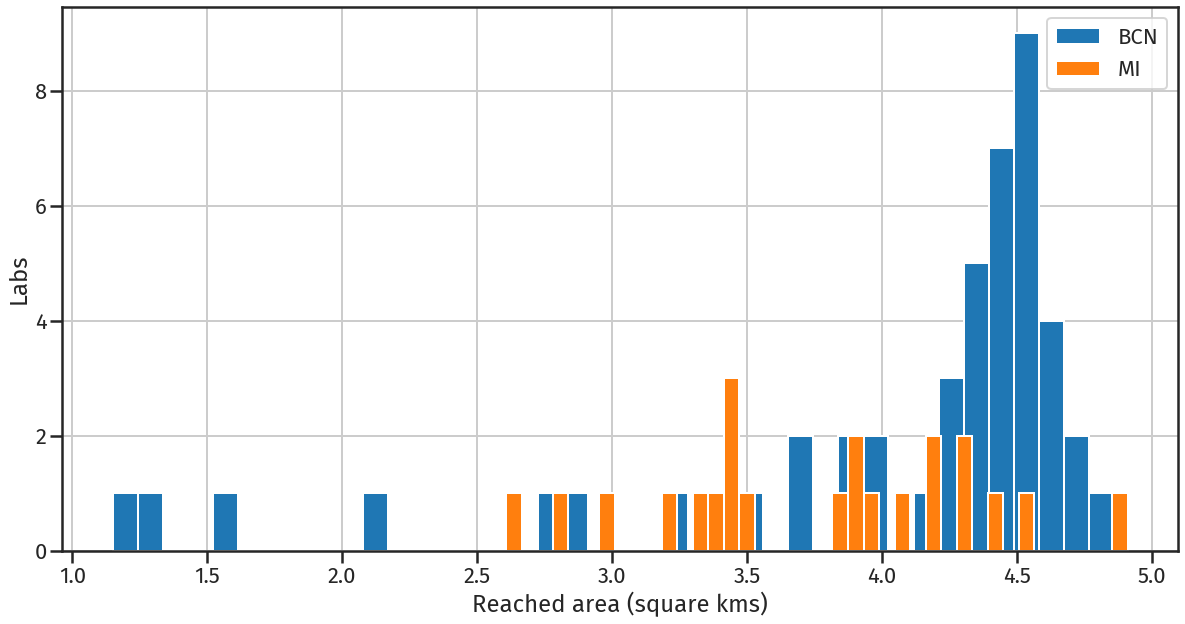

In [42]:
full_map_data.groupby("Cluster")["area"].plot(kind="hist", bins=40, figsize=(20,10), legend=True)
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_grouped_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_grouped_hist.png", dpi=300, bbox_inches="tight")

plot the data 

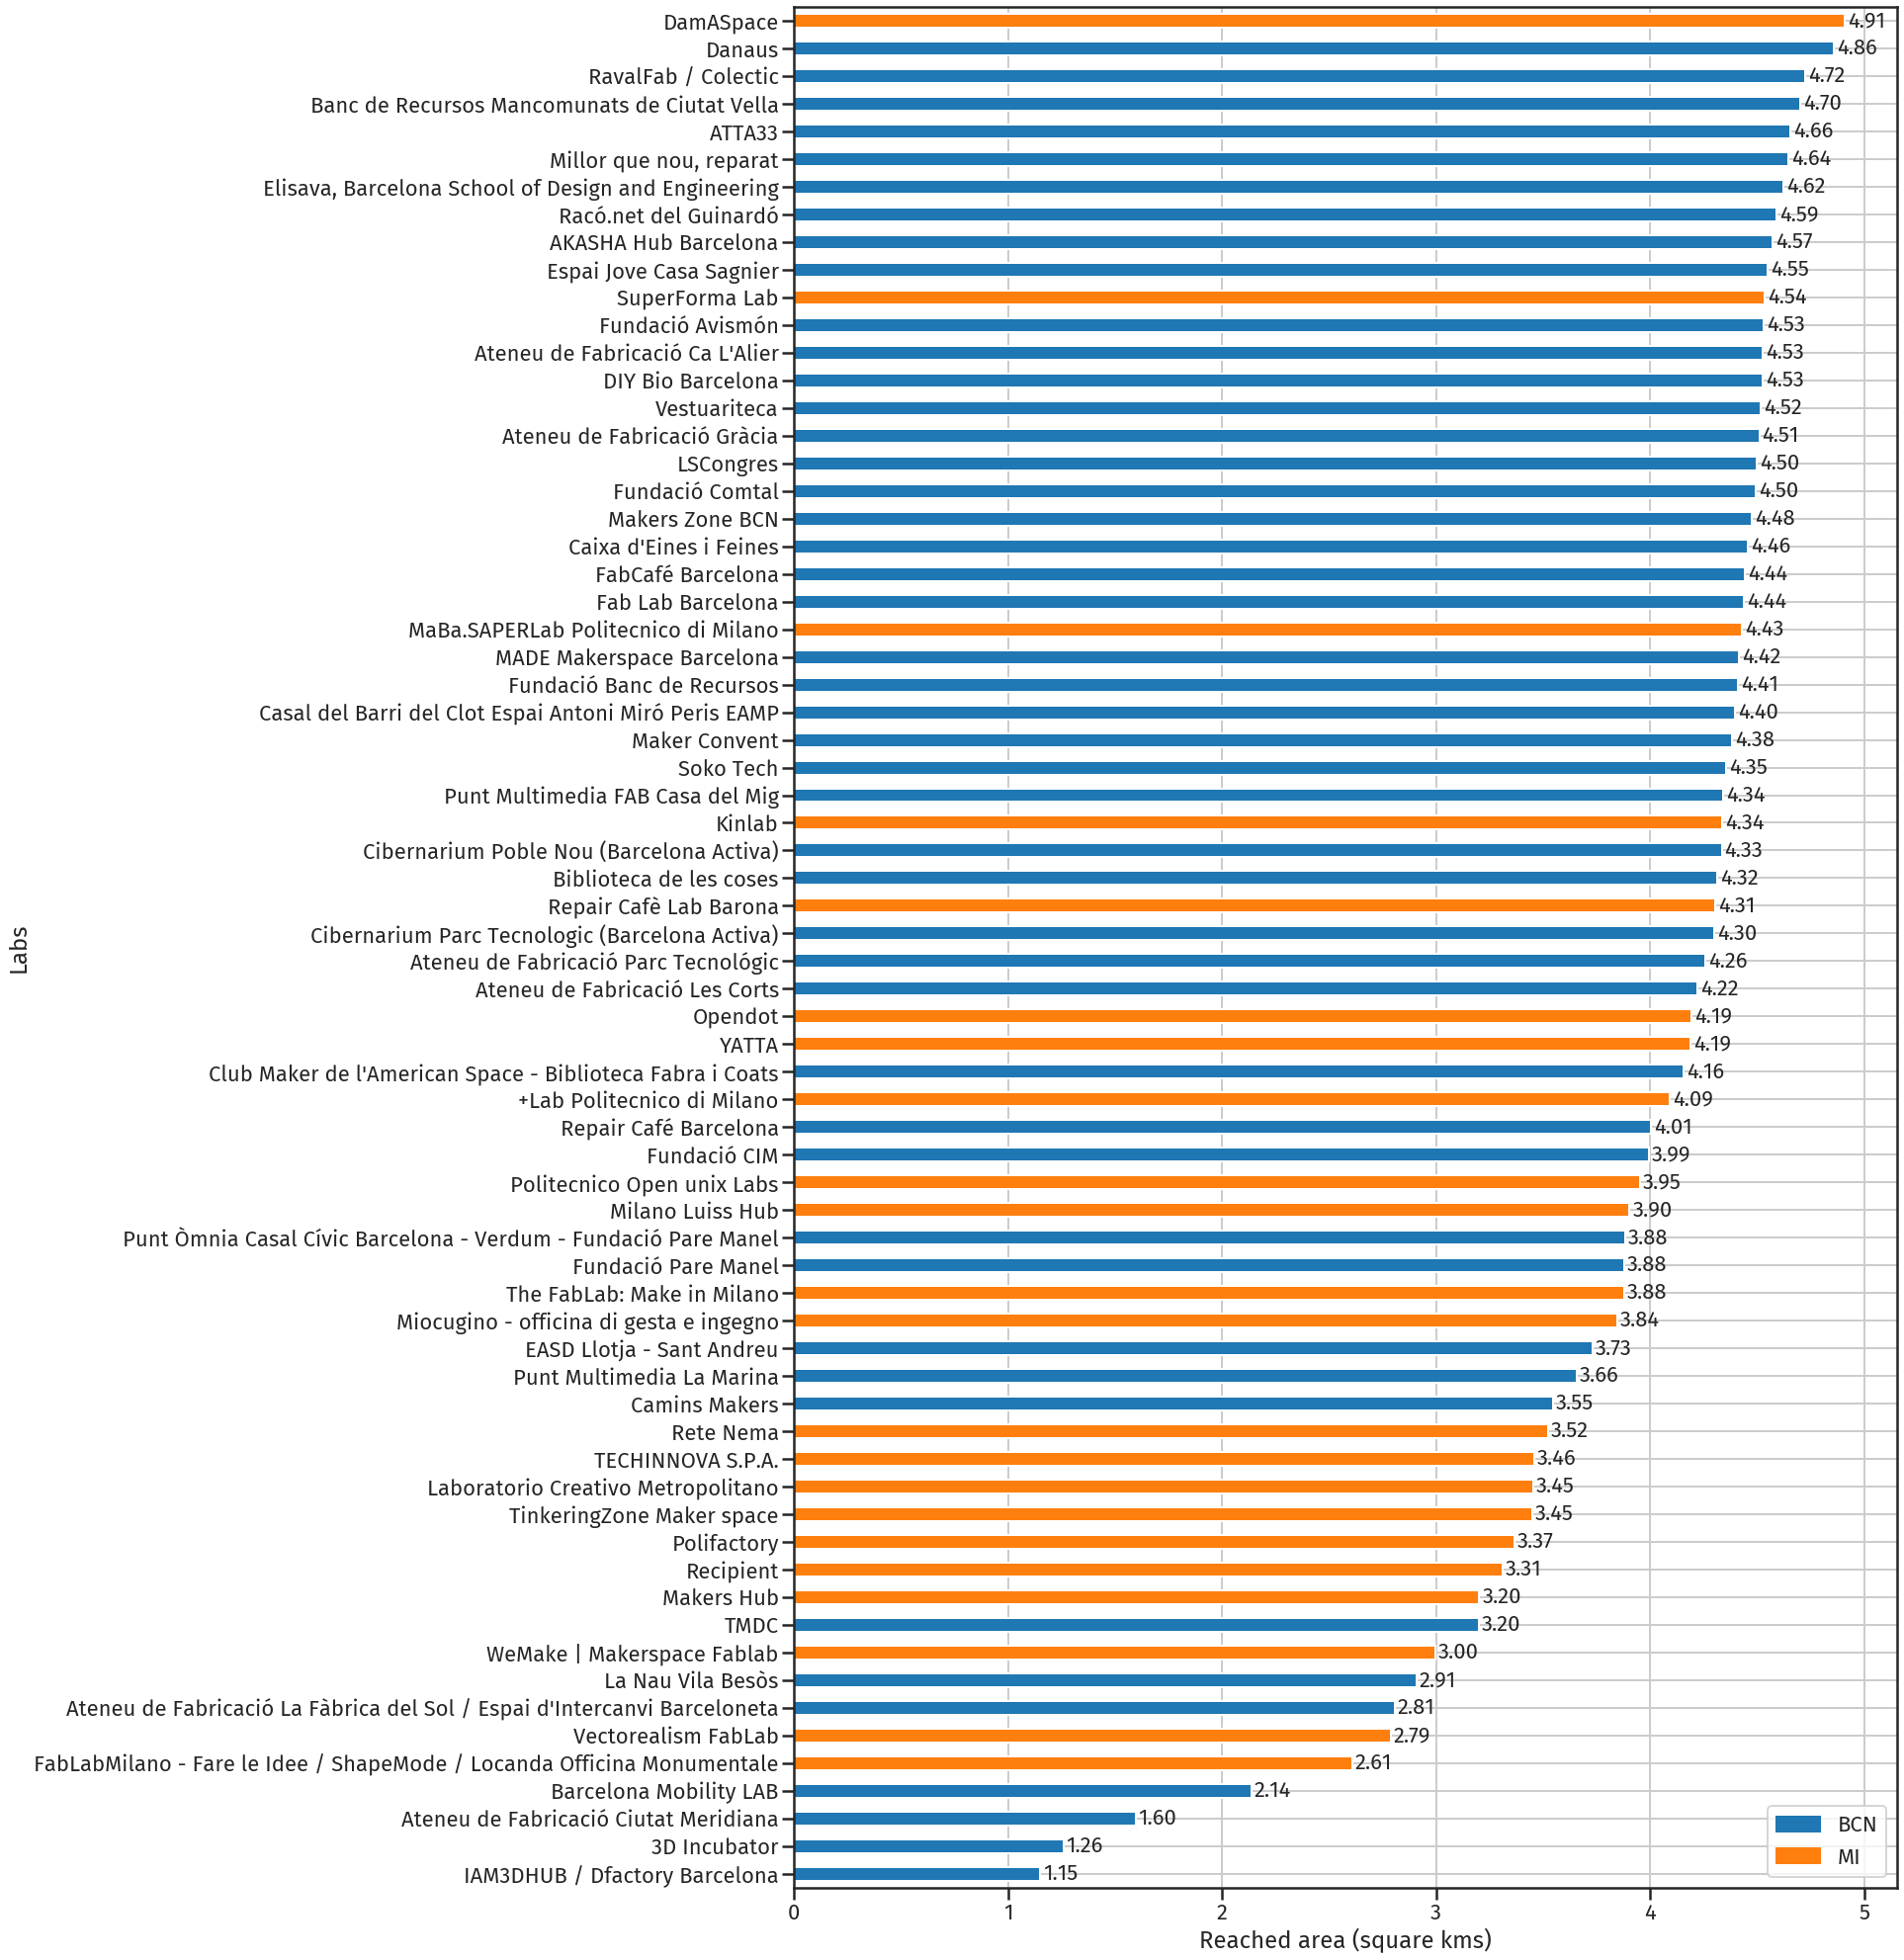

In [43]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['area'])['area'].plot(kind='barh', color=[colors[i] for i in full_map_data.sort_values(by=['area'])['Cluster']], figsize=(20,35), legend=True)
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_grouped_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_grouped_bar.png", dpi=300, bbox_inches="tight")

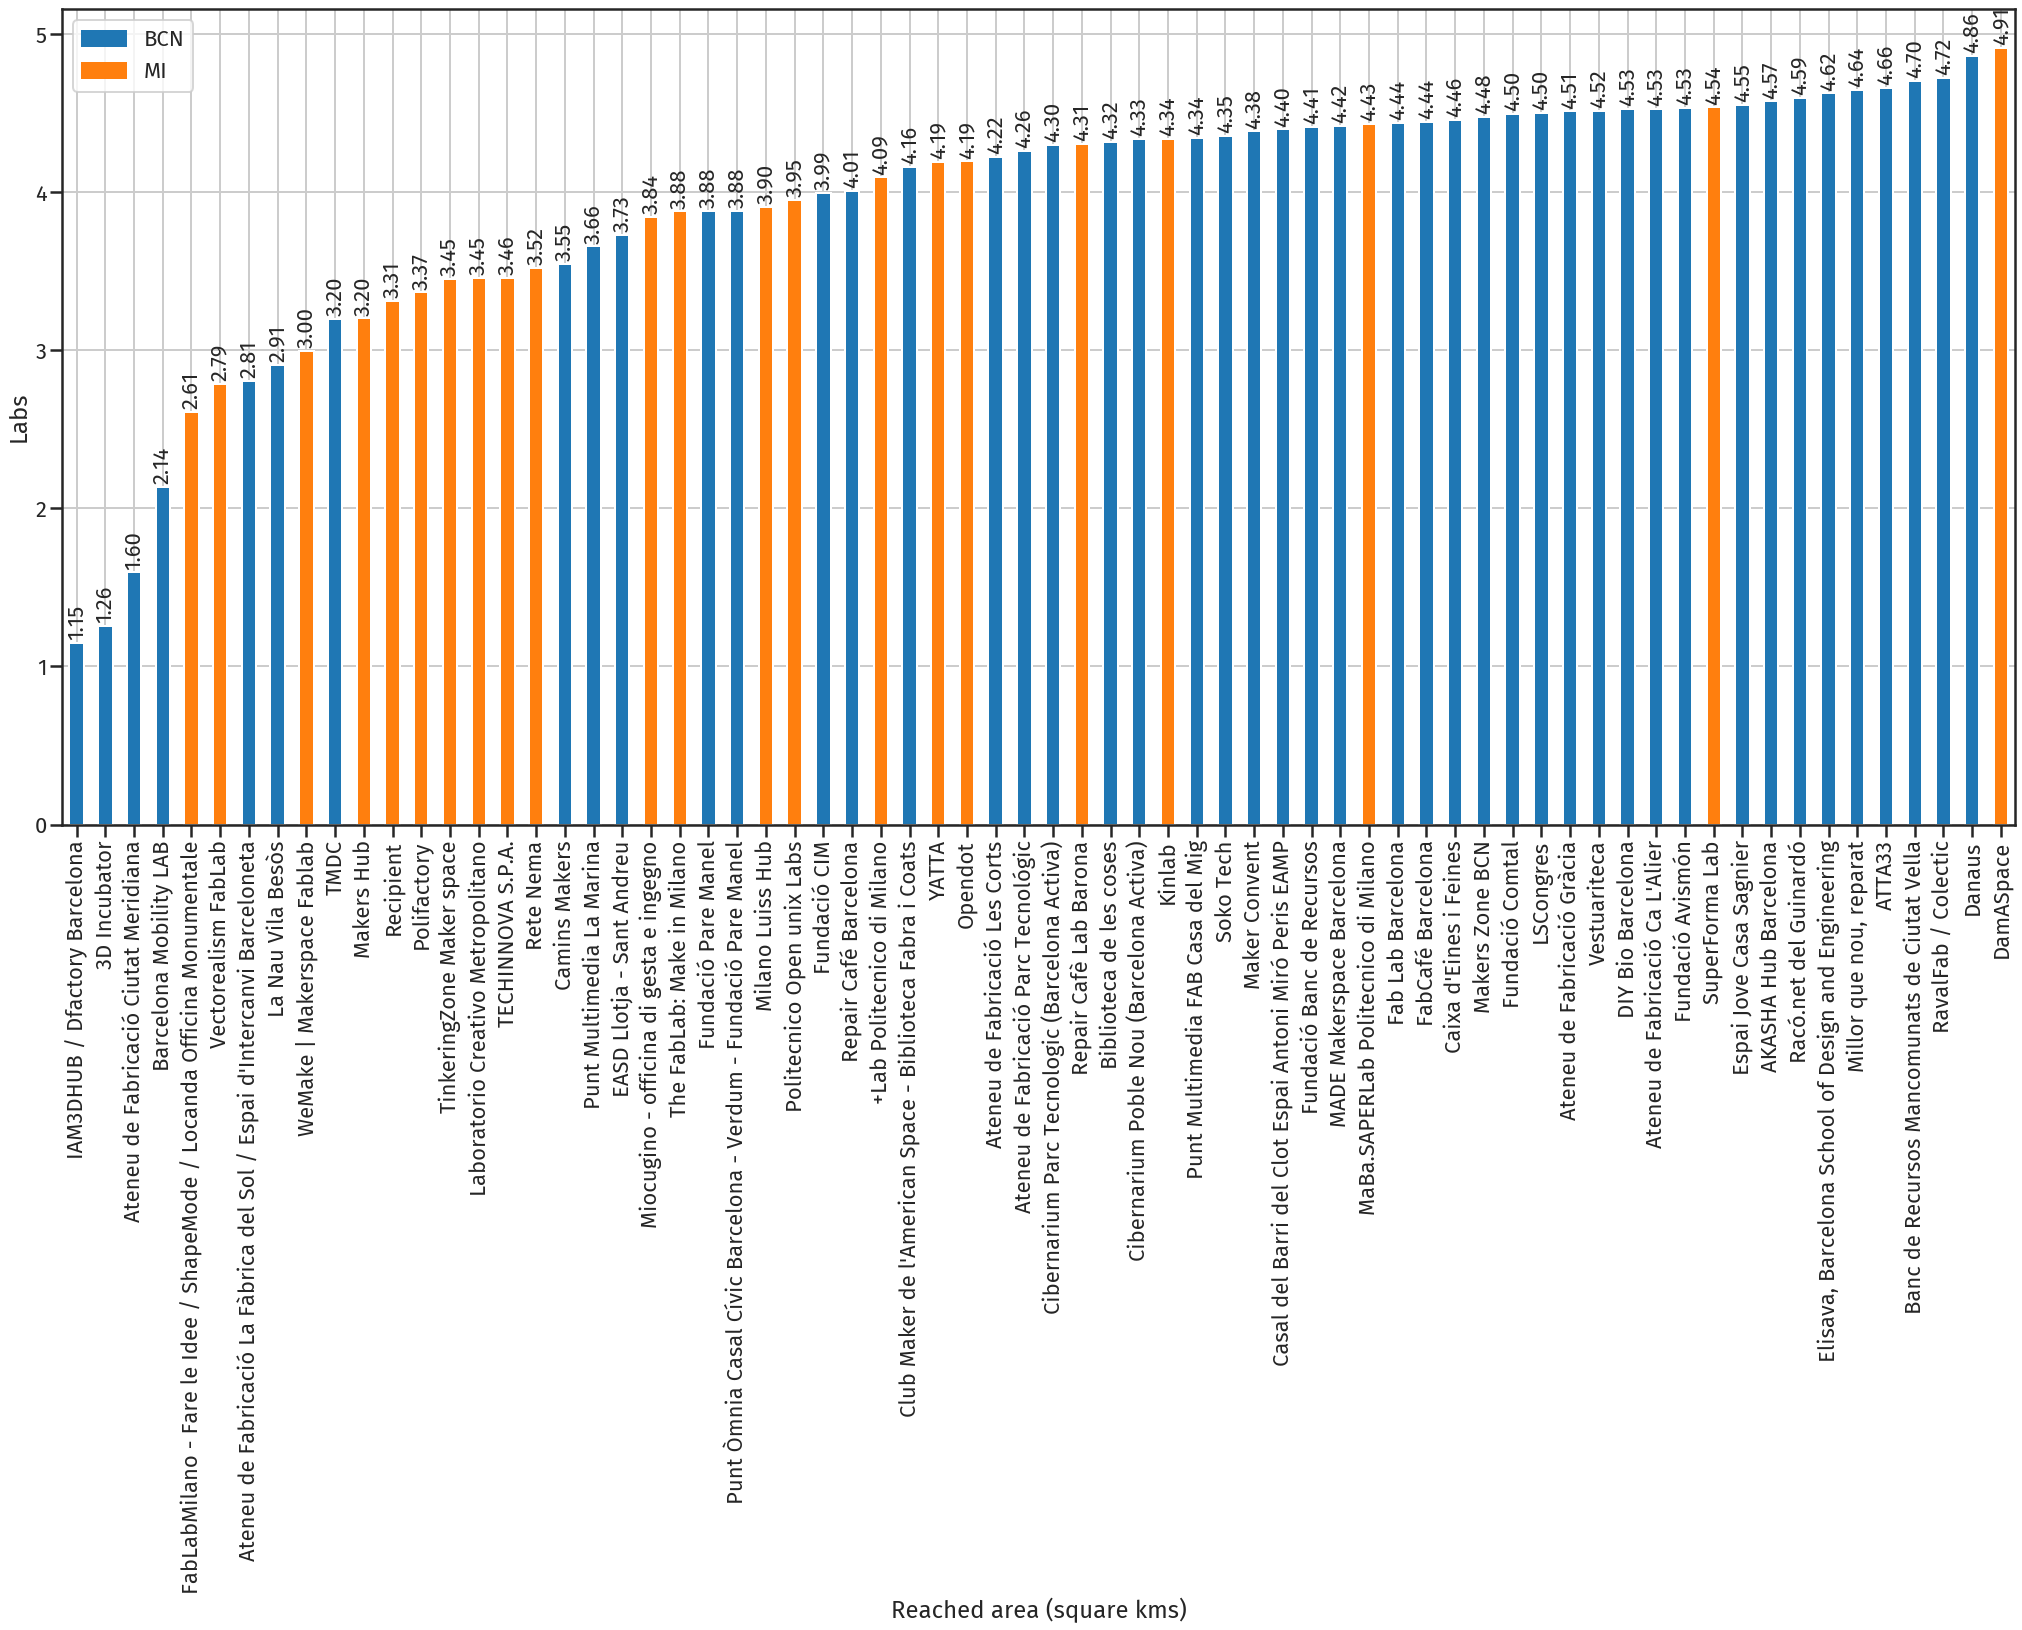

In [44]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['area'])['area'].plot(kind='bar', color=[colors[i] for i in full_map_data.sort_values(by=['area'])['Cluster']], figsize=(35,15), legend=True)
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3, rotation=90)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reached area (square kms)')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_area_grouped_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_area_grouped_bar_vertical.png", dpi=300, bbox_inches="tight")

plot the data

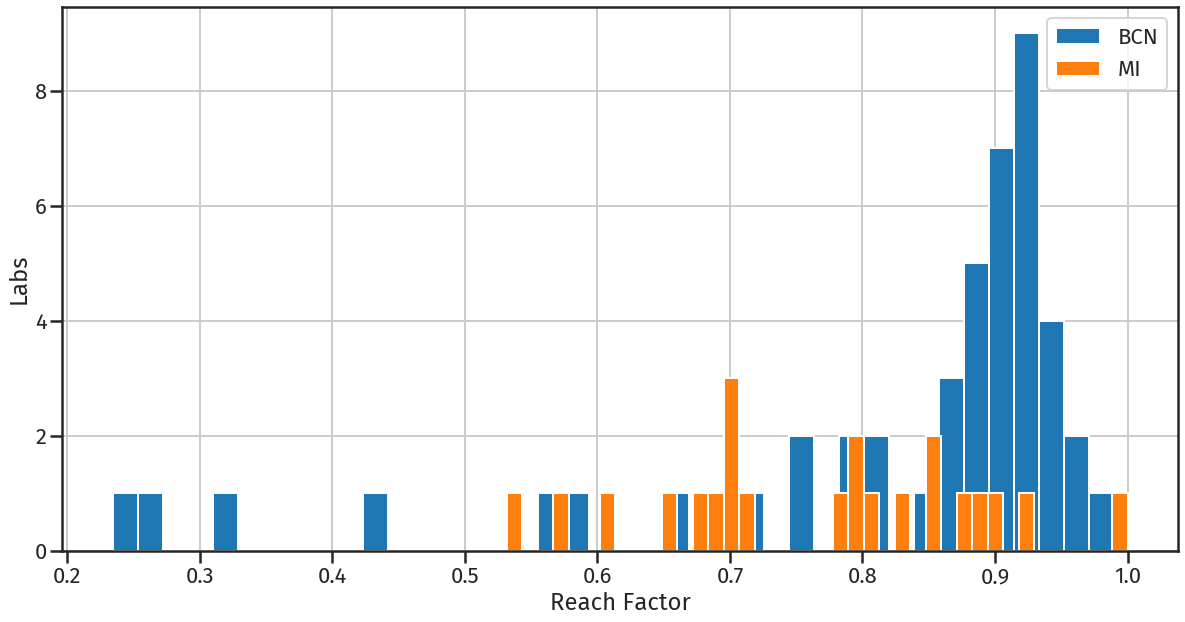

In [45]:
full_map_data.groupby("Cluster")["reachfactor"].plot(kind="hist", bins=40, figsize=(20,10), legend=True)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_grouped_hist.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_grouped_hist.png", dpi=300, bbox_inches="tight")

plot the data

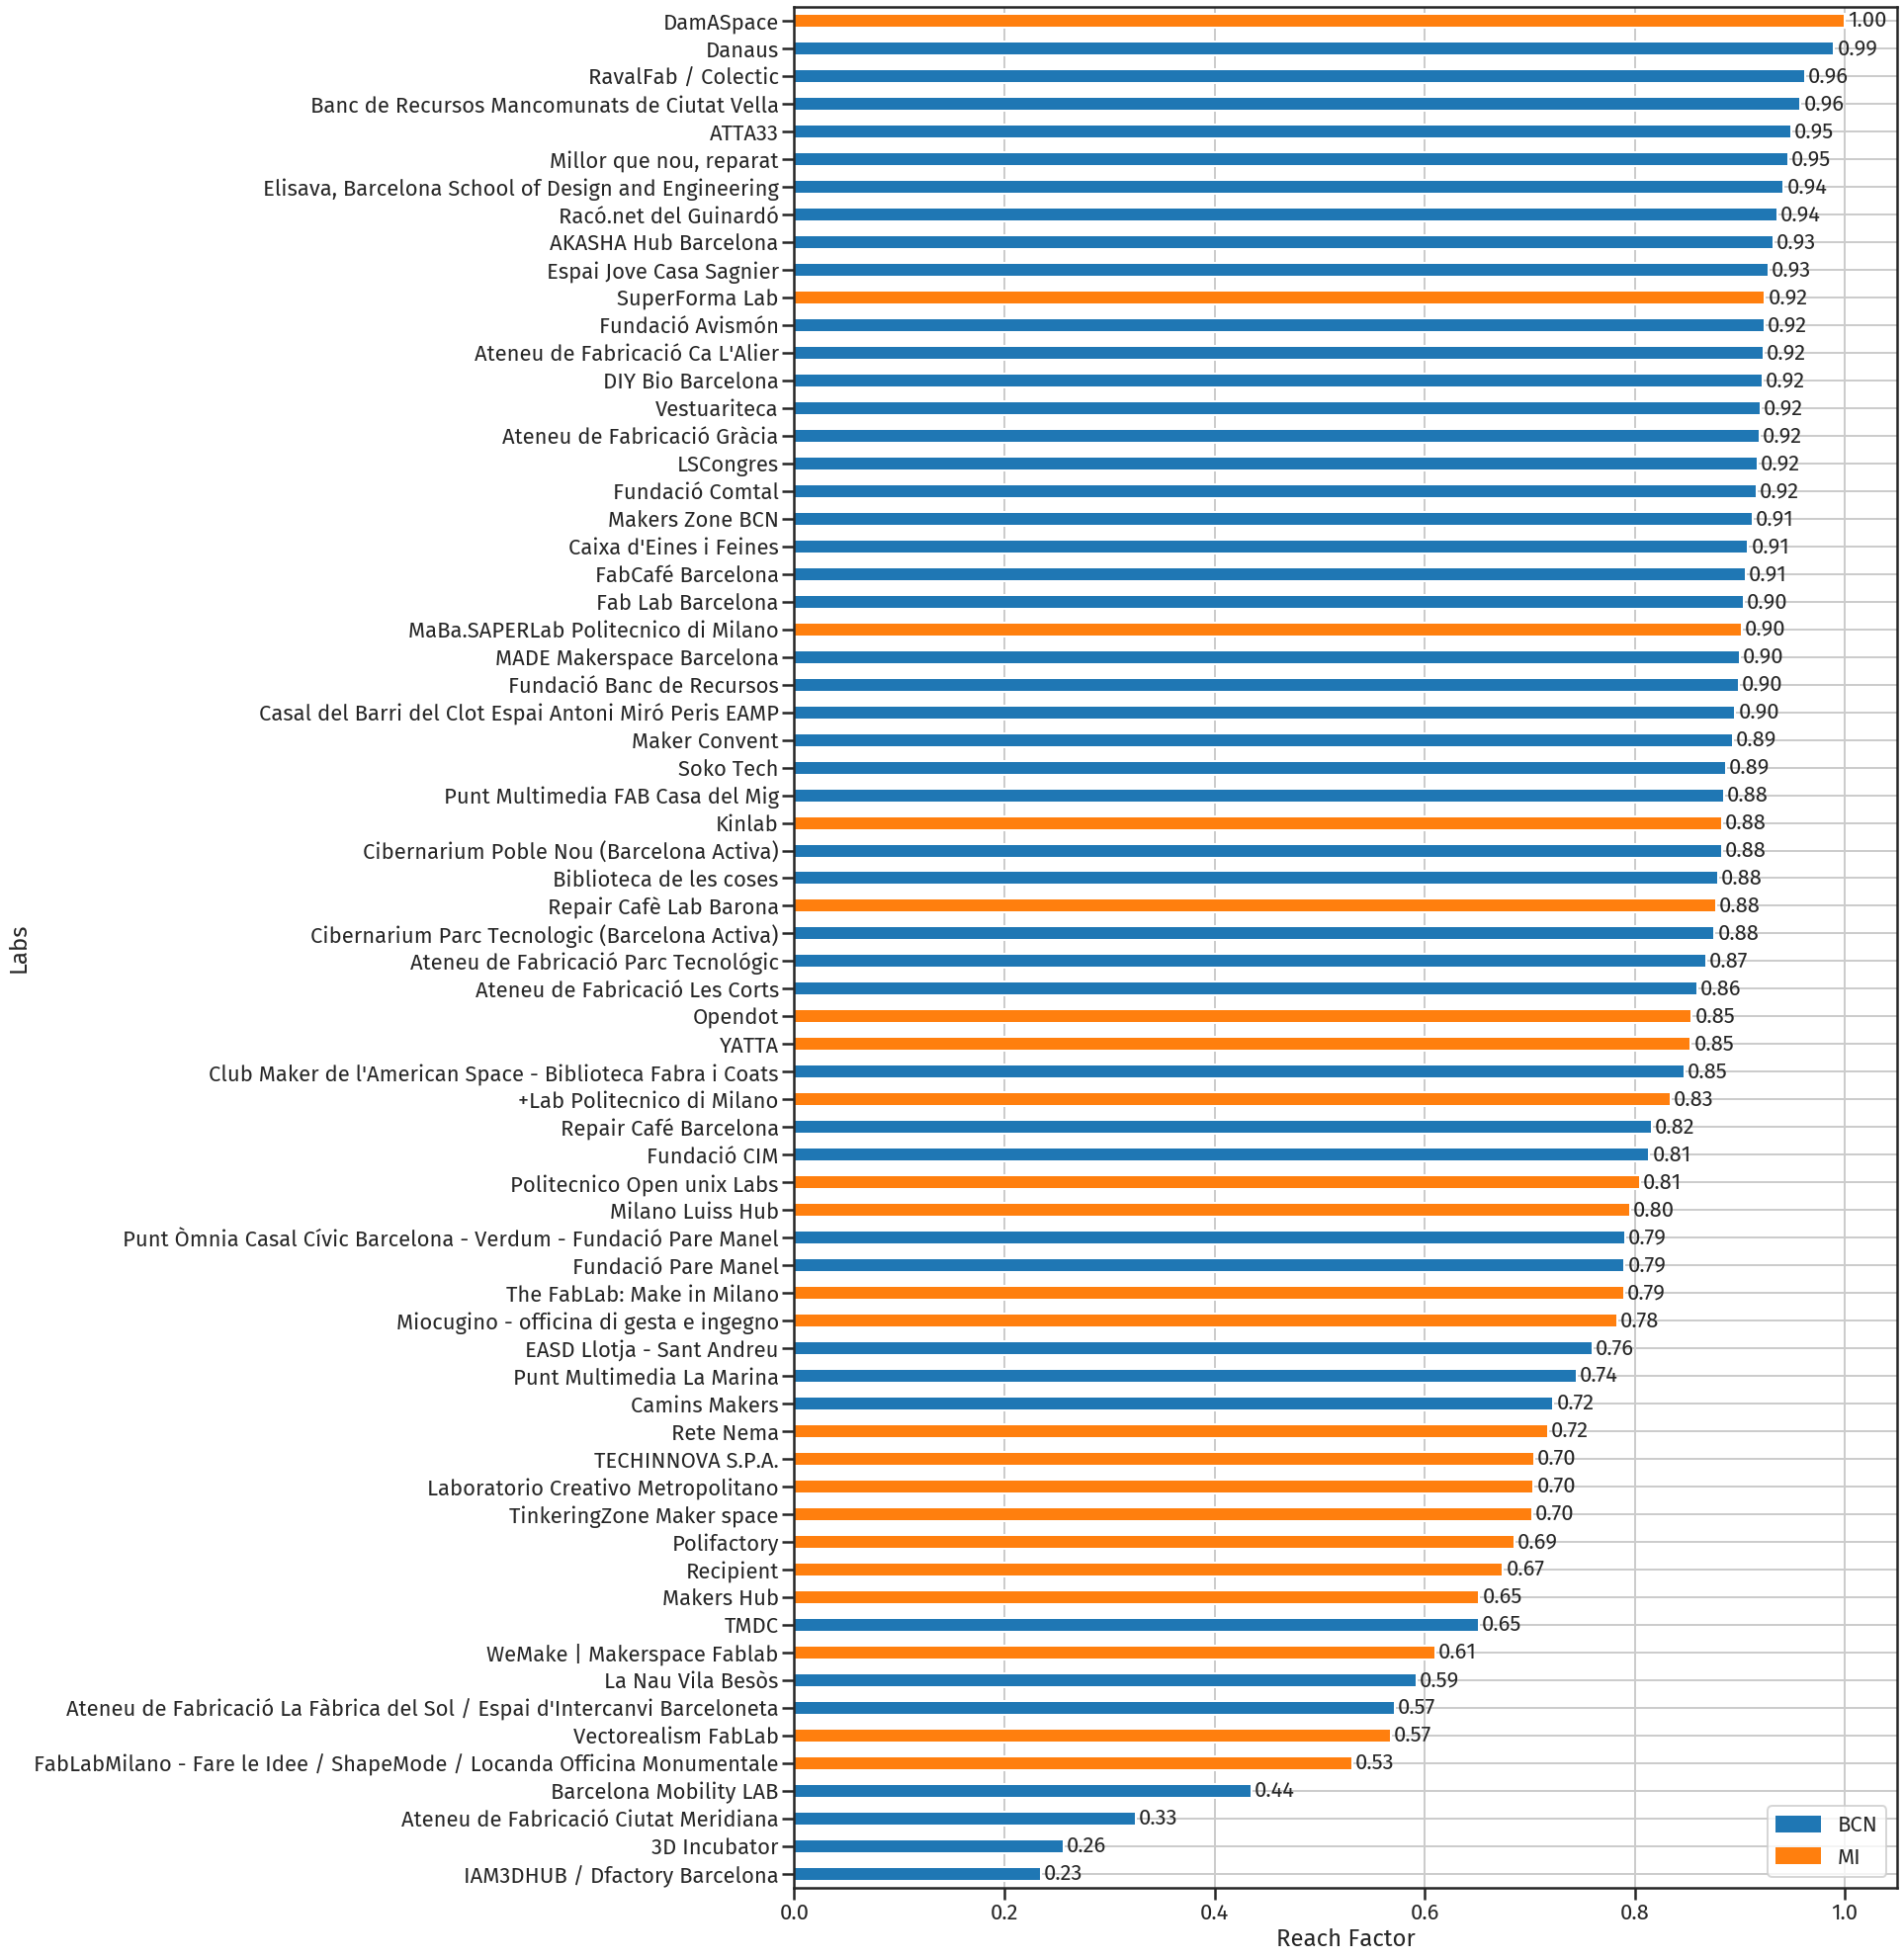

In [46]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['reachfactor'])['reachfactor'].plot(kind='barh', color=[colors[i] for i in full_map_data.sort_values(by=['reachfactor'])['Cluster']], figsize=(20,35), legend=True)
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_grouped_bar.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_grouped_bar.png", dpi=300, bbox_inches="tight")

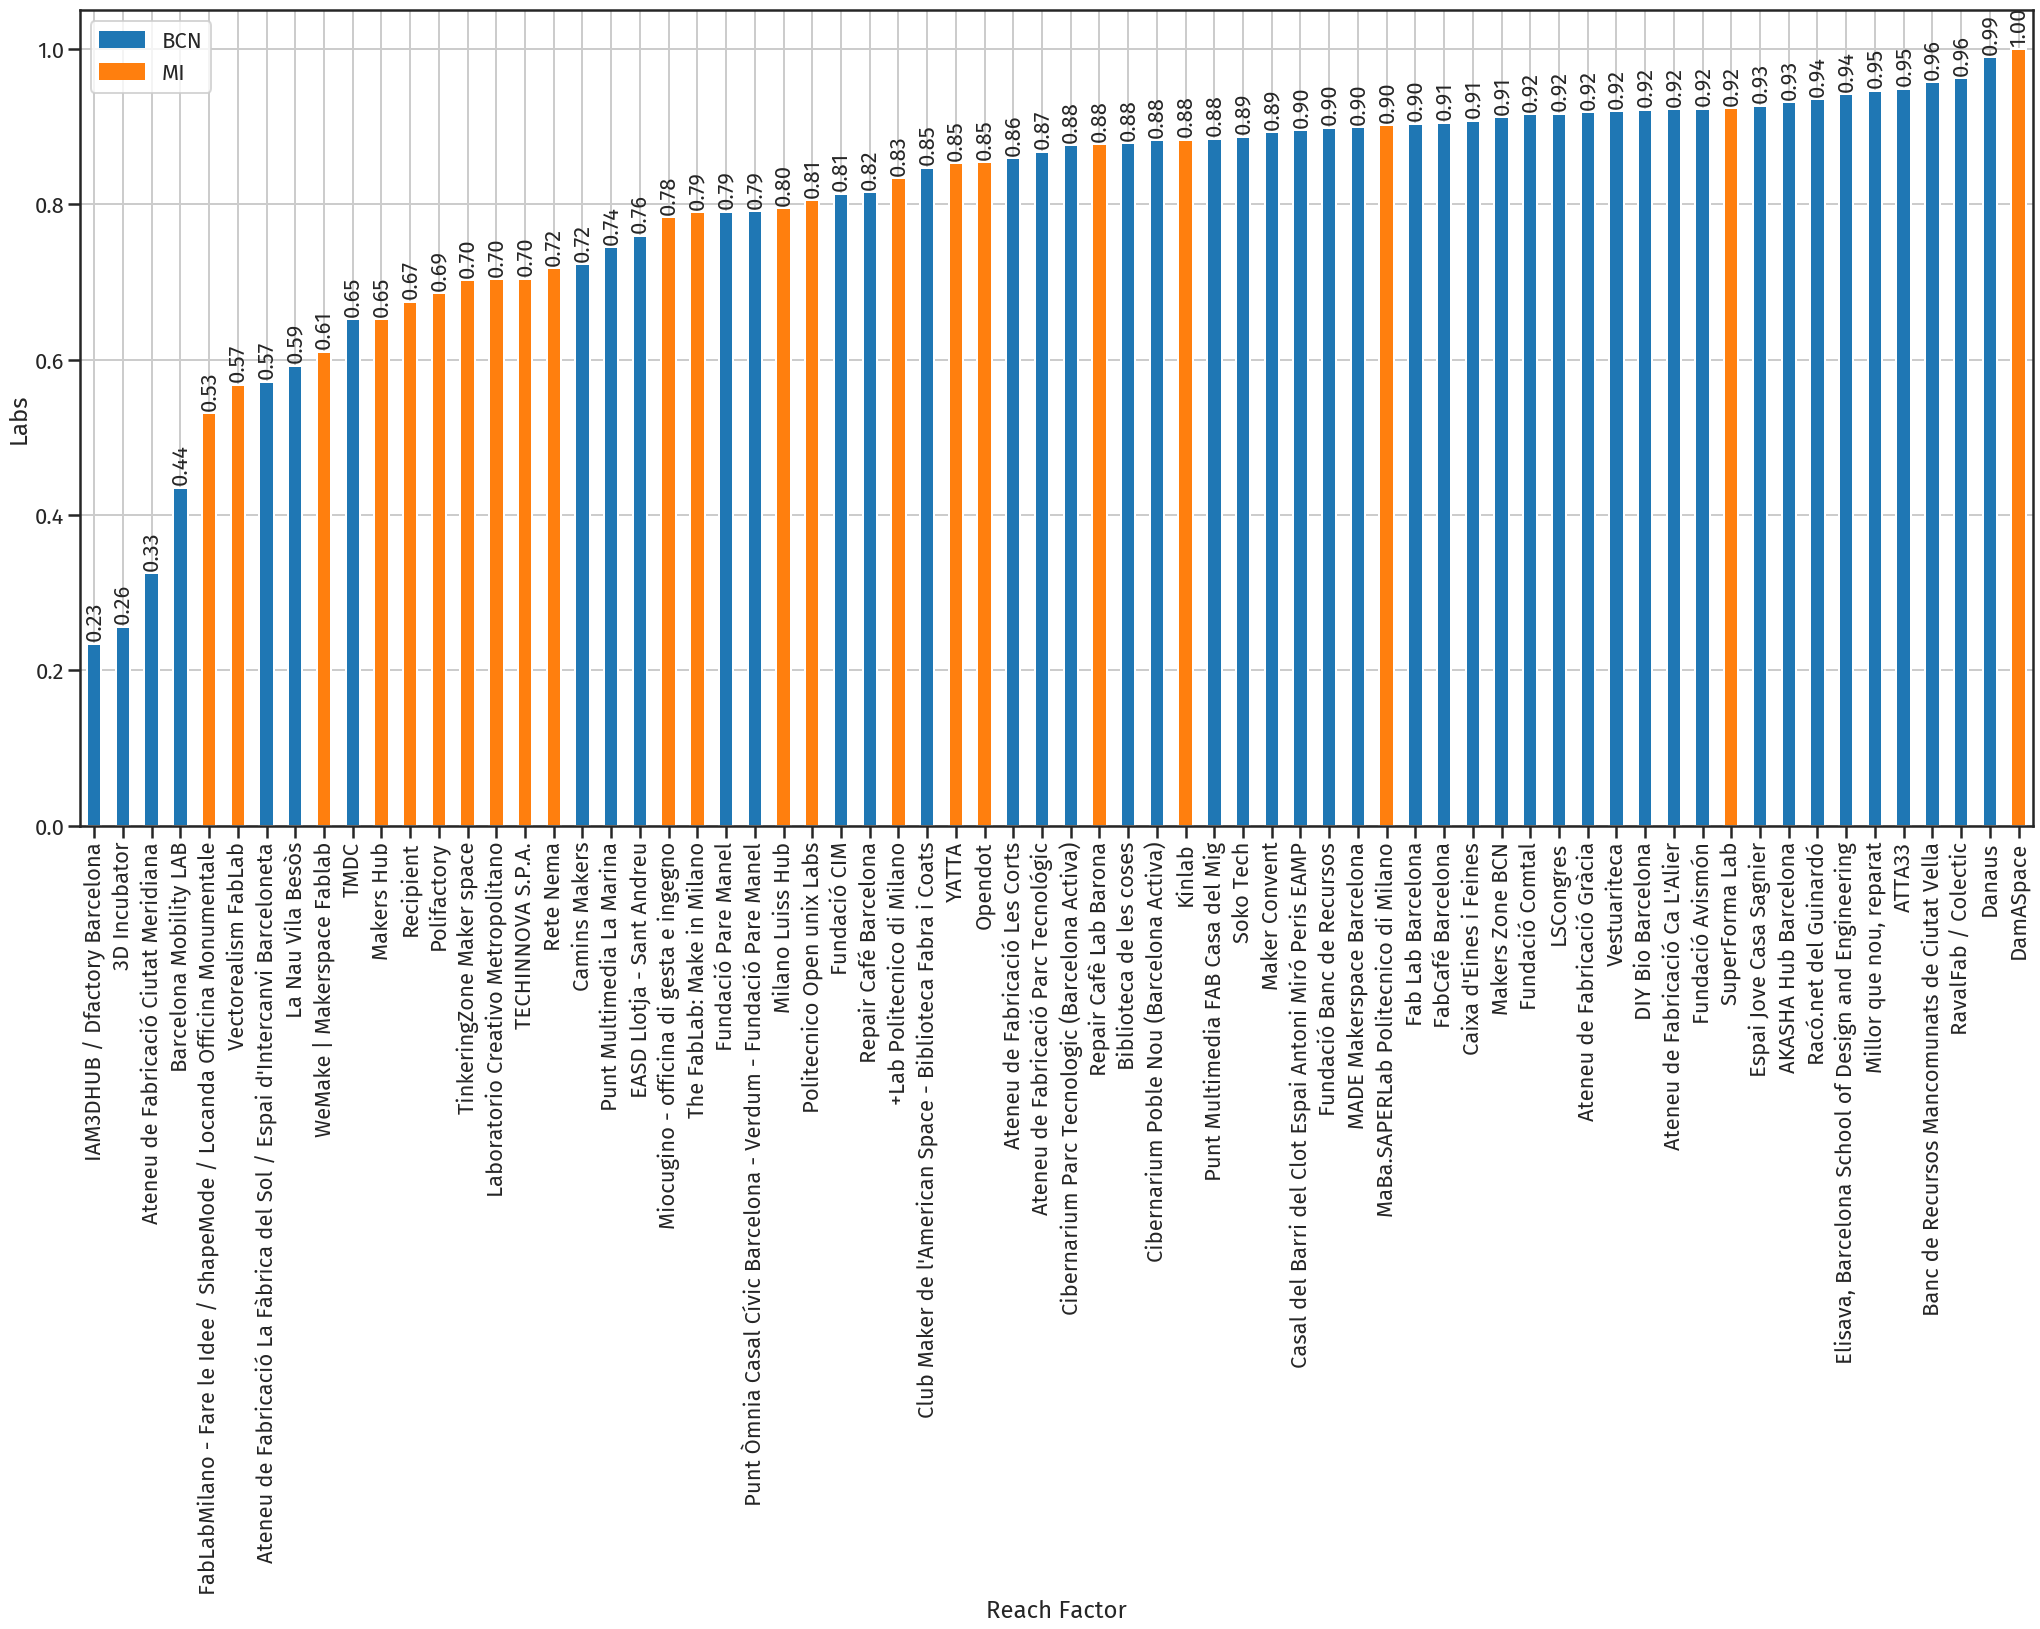

In [47]:
colors = {'BCN': sns.color_palette()[0], 'MI': sns.color_palette()[1]}
ax = full_map_data.sort_values(by=['reachfactor'])['reachfactor'].plot(kind='bar', color=[colors[i] for i in full_map_data.sort_values(by=['reachfactor'])['Cluster']], figsize=(35,15), legend=True)
ax.bar_label(ax.containers[0], fmt="%.2f", size=22, padding=3, rotation=90)
legend_elements = [Patch(facecolor=colors['BCN'], edgecolor=colors['BCN'],label='BCN'), Patch(facecolor=colors['MI'], edgecolor=colors['MI'],label='MI')]
ax.legend(handles=legend_elements)
plt.xlabel('Reach Factor')
plt.ylabel('Labs')
plt.grid()
plt.savefig("svg" + os.sep + "city_labs_reachfactor_grouped_bar_vertical.svg", bbox_inches="tight")
plt.savefig("png" + os.sep + "city_labs_reachfactor_grouped_bar_vertical.png", dpi=300, bbox_inches="tight")

### Isochrones

create the map

In [48]:
m=folium.Map(location=[41.396721,2.1943200000000003],tiles='stamentoner')
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

In [49]:
for iso in data:
  folium.GeoJson(iso, name="geojson").add_to(m)
for loc in locations:
  #folium.Marker(location=[locations[loc][1],locations[loc][0]],popup=loc,tooltip=loc).add_to(folium.FeatureGroup(name='Labs').add_to(m))
  folium.Circle(
    radius=30,
    location=[locations[loc][1],locations[loc][0]],
    popup=loc,
    tooltip=loc,
    color="crimson",
    fill="crimson",
).add_to(m)


show the map

red points = labs<Br/>
blu lines = isocrones 15' for each lab as center

In [50]:
folium.LayerControl().add_to(m)
m

save the web map

In [51]:
m.save("html" + os.sep + "city_isochrones.html")

### Isochrones with color from population reached

create the legend with a graduated color scale (yellow less, blu more)

In [52]:
linear = cmp.LinearColormap(
    ['yellow', 'green', 'blue'],
    vmin=map_data['total_pop'].min(), vmax=map_data['total_pop'].max(),
    caption='Total population'
)
linear

create the map

In [53]:
m=folium.Map(location=[41.396721,2.1943200000000003],tiles='stamentoner')
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

In [54]:
for iso in data:
  fillColor = map_data.loc[iso["name"]]["total_pop"]
  folium.GeoJson(iso, 
                 name="geojson", 
                 style_function=lambda feature: {
                     "fillColor": linear(feature["properties"]["total_pop"]),
                     "fillOpacity": 0.3,
                     "color": "gray",
                     "weight": 1,
                     "dashArray": ''
                     },
                 ).add_to(m)

for loc in locations:
    #folium.Marker(location=[locations[loc][1],locations[loc][0]],popup=loc,tooltip=loc).add_to(folium.FeatureGroup(name='Labs').add_to(m))
    folium.Circle(
        radius=30,
        location=[locations[loc][1],locations[loc][0]],
        popup=loc,
        tooltip=loc,
        fill=True,
        color="crimson",
        fillColor="crimson"
    ).add_to(m)

folium.LayerControl().add_to(m)
m.add_child(linear)

save the map

In [55]:
m.save("html" + os.sep + "city_isochrones_popcolor.html")

add labels to the map

In [56]:
m=folium.Map(location=[41.396721,2.1943200000000003],tiles='stamentoner')
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)

for iso in data:
  fillColor = map_data.loc[iso["name"]]["total_pop"]
  folium.GeoJson(iso, 
                 name="geojson", 
                 style_function=lambda feature: {
                     "fillColor": linear(feature["properties"]["total_pop"]),
                     "fillOpacity": 0.3,
                     "color": "gray",
                     "weight": 1,
                     "dashArray": ''
                     },
                 ).add_to(m)

for loc in locations:
    #folium.Marker(location=[locations[loc][1],locations[loc][0]],popup=loc,tooltip=loc).add_to(folium.FeatureGroup(name='Labs').add_to(m))
    folium.Circle(
        radius=30,
        location=[locations[loc][1],locations[loc][0]],
        popup=loc,
        tooltip=loc,
        fill=True,
        color="crimson",
        fillColor="crimson"
    ).add_to(m)
    folium.map.Marker(
        [locations[loc][1] + 0.0, locations[loc][0] - 0.0],
        icon=folium.features.DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="background-color: rgba(255, 255, 255, 0.75); padding: 5px; font-size: 10px; font-family:'+'Fira Sans;'+'">'+loc+'</div>',
        )
    ).add_to(m)

folium.LayerControl().add_to(m)
m.add_child(linear)

save the map

In [57]:
m.save("html" + os.sep + "city_isochrones_popcolor_labels.html")